In [14]:
# Imports

import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import math
import sys
import h5py

from __future__ import division, print_function

import illustris_api as ia

from numpy import loadtxt
from os import listdir

In [303]:
# Illustris API Configuration
ia.set_apikey('4e2c93455bbc8e991a91a61ef5e11daa')

h = 0.704

snap = 76
z = 1.4

lower = 0.0199
upper = 0.02

def test_plot(fname):
    f = h5py.File(fname,'r')
    x = f['PartType0']['Coordinates'][:,0]
    z = f['PartType0']['Coordinates'][:,1]
    dens = numpy.log10(f['PartType0']['Masses'][:])
    import matplotlib.pyplot as pyplot
    pyplot.figure()
    pyplot.hist2d(z,x,weights=dens,bins=[150,100])
    pyplot.show()


files = None
#files = ['cutout_41094.hdf5.orig'] # uncomment and set this to suppress to downloading

if files is None: 

    halo_data_prelim = ia.obtain_halos_by_mass(lower, upper, snap)

    c = halo_data_prelim['count']
    if ia.DEBUG: print(c)

    halo_ids, halo_data = ia.obtain_subhalos_data(halo_data_prelim, snap, z)

    halo_ids, halo_data = ia.filter_haloids(halo_ids, halo_data, filters=[ia.filter_non_zero_mass, ia.filter_star_mass, ia.filter_fluid_mass], args=[None, {'lower': 0.0001, 'upper': 0.0995}, {'lower': 0.00001, 'upper': 0.01}])

    if ia.DEBUG: print(halo_ids[:])

    ia.store_metadata(halo_data)

    files = ia.obtain_cutouts(halo_data, gascols=['Coordinates', 'Density', 'GFM_Metallicity', 'Masses', 'SmoothingLength', 'Velocities'], starcols=['Coordinates', 'Masses', 'Velocities','GFM_Metallicity'], count=None)

    Ldata = []
    ia.detilt_files(files, halo_data, L_outputs=Ldata)
    if ia.DEBUG: print(Ldata)

ia.process_cutouts_for_splash(files)

Setting API Key to 4e2c93455bbc8e991a91a61ef5e11daa
 Obtaining subhalos in mass range 0.0199 to 0.02 at snapshot 76.000000
   404 subhalos will be obtained in 100-element chunks
 Obtaining metadata for 404 subhalos
     0 % done
     10 % done
     20 % done
     30 % done
     40 % done
     50 % done
     60 % done
     70 % done
     80 % done
     90 % done
     100 % done
Initial idn set = 404
404
Applying filter filter_non_zero_mass
 0 eliminated due to less than epsilon mass
 1 eliminated due to less than epsilon mass
 2 eliminated due to less than epsilon mass
 3 eliminated due to less than epsilon mass
 4 eliminated due to less than epsilon mass
 5 eliminated due to less than epsilon mass
 6 eliminated due to less than epsilon mass
 7 eliminated due to less than epsilon mass
 8 eliminated due to less than epsilon mass
 9 eliminated due to less than epsilon mass
 10 eliminated due to less than epsilon mass
 11 eliminated due to less than epsilon mass
 12 eliminated due to less 

 Obtaining cutout of halo 339551 at redshift 1.400000
 Columns requested:Coordinates Masses Velocities GFM_Metallicity Coordinates Density GFM_Metallicity Masses SmoothingLength Velocities 
 Obtaining cutout of halo 428049 at redshift 1.400000
 Columns requested:Coordinates Masses Velocities GFM_Metallicity Coordinates Density GFM_Metallicity Masses SmoothingLength Velocities 
 Obtaining cutout of halo 504766 at redshift 1.400000
 Columns requested:Coordinates Masses Velocities GFM_Metallicity Coordinates Density GFM_Metallicity Masses SmoothingLength Velocities 
 Obtaining cutout of halo 571300 at redshift 1.400000
 Columns requested:Coordinates Masses Velocities GFM_Metallicity Coordinates Density GFM_Metallicity Masses SmoothingLength Velocities 
Limiting angular momentum calculation to r < 2.2876
Limiting angular momentum calculation to r < 2.4199
Limiting angular momentum calculation to r < 3.5579
Limiting angular momentum calculation to r < 0
Limiting angular momentum calculation

/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=1.4/illustris_api.py:1037: RuntimeWarning: invalid value encountered in true_divide
  Lhat = totL/modL # this is the direction the total angular momentum vector points


In [304]:
# Creates arrays of stellar mass, fluid mass, and virial mass

stellar_mass = []
fluid_mass = []
virial_mass = []

# Loops over halo data and appends stellar masses and fluid masses to arrays
for h in halo_data:
    stellar_mass.append(h['mass_stars'])
    fluid_mass.append(h['mass_gas'])
    
# Loops over halo data and halo ids to create virial mass array for the galaxies that met the mass cuts
for i in range(0,len(halo_data_prelim['results'])):
    for j in range(0,len(halo_ids)):
        if halo_data_prelim['results'][i]['id'] == halo_ids[j]:
            virial_mass.append(halo_data_prelim['results'][i]['mass_log_msun'])
            
print(halo_ids)    
print(stellar_mass)
print(fluid_mass)
print(virial_mass)


[315883, 339551, 428049, 504766, 571300]
[0.000203, 0.000231, 0.0002, 0.000116, 0.000137]
[0.002077, 0.001664, 0.003401, 0.004396, 0.004352]
[8.45162945846131, 8.45284889824096, 8.451585843650136, 8.452239606353604, 8.451716674945567]


In [305]:
# This function grabs the HI abundance from Illustris and takes the mean value

def get_HI(halo_ids):
    f = []
    HI = []
    mean = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=1.4/cutout_'+str(i)+'.hdf5', 'r')
        HI.append(f['PartType0']['NeutralHydrogenAbundance'][:])
        
    for j in range(0,len(HI)):
        mean.append(numpy.ndarray.mean(HI[j]))

    return mean

In [306]:
HI_abundance = get_HI(halo_ids)
print(HI_abundance)
print(halo_ids)

[0.42925802, 0.87703365, 0.7758643, 0.68849784, 0.78211033]
[315883, 339551, 428049, 504766, 571300]


In [307]:
# This function converts HI abundance to HI mass

def get_HI_mass(HI_abundance,fluid_mass):
    
    number_density = []
    MHI = []
    
    # This is the mass of a proton in units of 10^10 Msol/h
    m_p = 1.6726219e-27 * (1 / 1.989e30) * (1 / 10e10) * 0.704 # units of 10^10 Msol/h
    
    # This loops over the fluid masses and converts it to the number density of hydrogen
    for m in fluid_mass:
        n = m / m_p 
        number_density.append(n)
     
    # This loops over the HI abundance and multiplies the number density of hydrgoen by the HI abundance to get the number density of HI
    # It then multiplies the number density of HI by the mass of a proton to obtain the mass of HI
    for i in range(0,len(HI_abundance)):
        
        n_HI = HI_abundance[i] * number_density[i]
        mhi = n_HI * m_p
        MHI.append(mhi)
        
    return MHI

In [308]:
HI = get_HI_mass(HI_abundance,fluid_mass)
print(HI)
print(fluid_mass)
print(halo_ids)

[0.0008915689049065112, 0.0014593839950561524, 0.002638714494884014, 0.0030266365106105804, 0.0034037441711425778]
[0.002077, 0.001664, 0.003401, 0.004396, 0.004352]
[315883, 339551, 428049, 504766, 571300]


In [309]:
# This only appends Lhat vectors that have values and removes nan values
# It creates an array of the indices called 'entry' that have real values
Lhat = []
entry = []
for i in range(0,len(Ldata)):
    Lhat.append(Ldata[i][2])
    angm = Ldata[i][2]
    if abs(angm[0])>0:
        entry.append(i)
        
print(Lhat)

[array([nan, nan, nan], dtype=float32), array([nan, nan, nan], dtype=float32), array([ 0.52042365,  0.85173833, -0.06083704], dtype=float32), array([nan, nan, nan], dtype=float32), array([nan, nan, nan], dtype=float32)]


In [310]:
# This function plots the metallicity distribution as a column density plot
# It reads in the filename and Lhat vector
# It plots the galaxy in all three planes
# It also does a check on which plane has the largest Lhat vector. It then plots the 'best view' of the galaxy in the other two planes 

def metallicity_plot(fname,Lhat):
    f = h5py.File(fname,'r')
    x = f['PartType0']['Coordinates'][:,0]
    z = f['PartType0']['Coordinates'][:,1]
    y = f['PartType0']['Coordinates'][:,2]
    
    met = f['PartType0']['GFM_Metallicity'][:]/0.0127
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    
    plt.figure()
    plt.hist2d(z,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
    plt.colorbar()
    #plt.clim(0.1, 1)
    plt.title(str(fname))
    plt.show()
    print('YZ-plane')

    plt.figure()
    plt.hist2d(x,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
    plt.colorbar()
    #plt.clim(0.1, 1)
    plt.title(str(fname))
    plt.show()
    print('XY-plane')

    plt.figure()
    plt.hist2d(z,x,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
    plt.colorbar()
    #plt.clim(0.1, 1)
    plt.title(str(fname))
    plt.show()
    print('XZ-plane')
    
    print("------------------------Best cutout--------------------------")
    

    if abs(Lhat[0]) >= abs(Lhat[1]) and abs(Lhat[0]) >= abs(Lhat[2]):
        plt.figure()
        plt.hist2d(z,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
        plt.colorbar()
        #plt.clim(0.1, 1)
        plt.title(str(fname))
        plt.show()
        print('YZ-plane')

    if abs(Lhat[1]) >= abs(Lhat[0]) and abs(Lhat[1]) >= abs(Lhat[2]):
        plt.figure()
        plt.hist2d(x,y,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
        plt.colorbar()
        #plt.clim(0.1, 1)
        plt.title(str(fname))
        plt.show()
        print('XY-plane')

    if abs(Lhat[2]) >= abs(Lhat[0]) and abs(Lhat[2]) >= abs(Lhat[1]):
        plt.figure()
        plt.hist2d(z,x,weights=met,bins=[200,100],norm=mpl.colors.LogNorm())
        plt.colorbar()
        #plt.clim(0.1, 1)
        plt.title(str(fname))
        plt.show()
        print('XZ-plane')
        
        
    # This plots the minimum and maximum metallicity
    print(min(met),max(met))
    print(Lhat)
    print("------------------------Best cutout--------------------------")

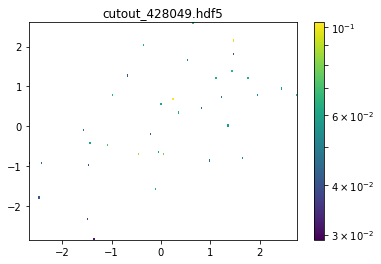

YZ-plane


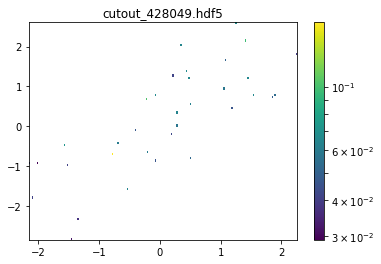

XY-plane


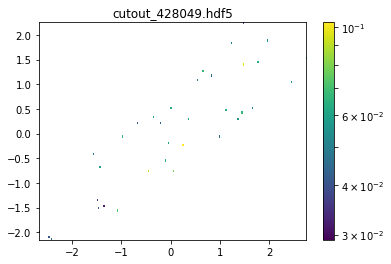

XZ-plane
------------------------Best cutout--------------------------


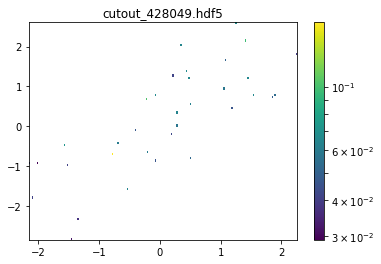

XY-plane
0.029120315 0.1026877
[ 0.52042365  0.85173833 -0.06083704]
------------------------Best cutout--------------------------


In [311]:
# This loops over all of the galaxies that don't have nan values and plots the metallicity distribution for each

for i in entry:
    metallicity_plot('cutout_'+str(halo_ids[i])+'.hdf5',Lhat[i]) 

In [312]:
# This function obtains the mean metallicity in solar units for a given galaxy

def get_metallicity(halo_ids):
    f = []
    Z = []
    mean = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=1.4/cutout_'+str(i)+'.hdf5', 'r')
        Z.append(f['PartType0']['GFM_Metallicity'][:]/0.0127)
    for j in range(0,len(Z)):
        mean.append(numpy.ndarray.mean(Z[j]))

    return mean

In [313]:
# This function obtains the total star formation rate in solar masses per year for a given galaxy

def get_SFR(halo_ids):
    f = []
    SFR = []
    mean = []
    total = []
    for i in halo_ids:
        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/z=1.4/cutout_'+str(i)+'.hdf5', 'r')
        SFR.append(f['PartType0']['StarFormationRate'][:])
    for j in range(0,len(SFR)):
        mean.append(numpy.ndarray.mean(SFR[j]))
    for k in range(0,len(SFR)):
        total.append(numpy.ndarray.sum(SFR[k]))

    return total

In [314]:
metallicity = get_metallicity(halo_ids)
print(metallicity)

starformation = get_SFR(halo_ids)
print(starformation)

[0.049319923, 0.028565539, 0.05789278, 0.031361926, 0.01589233]
[0.008574003, 0.00044914713, 0.004301008, 0.0003670594, 0.00062978256]


In [315]:
# This creates a text file with information about all galaxies that passed the mass cuts

with open("master_dwarf_z=1.4.txt", "a") as myfile:
    for i in range(0,len(halo_ids)):
        ids = halo_ids[i],stellar_mass[i],fluid_mass[i],virial_mass[i],HI_abundance[i], HI[i], [Lhat[i][0],Lhat[i][1],Lhat[i][2]], metallicity[i], starformation[i]
        myfile.write(str(ids)+'\n')

In [ ]:
metallicity = get_metallicity(halo_ids)
print(metallicity)

starformation = get_SFR(halo_ids)
print(starformation)

# This converts the stellar mass to units of solar masses
converted_stellar_mass = []
for i in stellar_mass:
    x = i*1e10*0.704
    converted_stellar_mass.append(x)

In [15]:
# This is the array of information about all of the galaxies that met the mass cuts
# I had a hard time trying to read in information from the text file so I just copied and pasted the information into an array
# It isn't the best way of doing things, but it works
# Note that I am ignoring the galaxies with nan values of Lhat in my analysis

all_data = [['halo_ids', 'stellar_mass', 'fluid_mass', 'virial_mass', 'HI_abundance', 'HI', 'Lhat', 'metallicity', 'starformation'],
[57813, 0.000135, 0.009889, 8.153468398843982, 0.71519405, 0.007072553925812244, [0.5254037, -0.85060686, 0.020469101], 0.16403142, 0.011227375],
[105989, 0.00034, 0.009713, 8.154723023412823, 0.6510106, 0.00632326569467783, [0.45553038, -0.44287258, -0.7722408], 0.38028285, 0.00080401974],
[107655, 0.000105, 0.009981, 8.156146304681002, 0.7513781, 0.007499505005657673, [0.37315872, 0.33443308, 0.86539423], 0.2647131, 0.000496075],
[151469, 0.000236, 0.00982, 8.154852605535789, 0.79139286, 0.007771477912664413, [0.62879026, 0.6467407, -0.43168193], 0.1137034, 0.001989479],
#(247223, 0.000207, 0.009838, 8.154377281942155, 0.833364, 0.008198635128974913, [nan, nan, nan], 0.23315825, 0.00035475104)
#(327782, 0.000107, 0.009914, 8.15333840298911, 0.8257488, 0.008186473615407943, [nan, nan, nan], 0.111416146, 0.0037086126)
[378477, 0.000205, 0.009798, 8.152557609663114, 0.80657023, 0.007902775132298468, [-0.34116182, -0.9340146, -0.10594985], 0.23045246, 0.005777667],
[712184, 0.000108, 0.00027, 8.155758599419215, 0.76356137, 0.00020616156935691834, [0.26126286, 0.90616393, -0.33257884], 0.029220045, 0.0005949176],
[24067, 0.00031, 0.009963, 8.164124628972031, 0.707234, 0.007046172591090203, [-0.9426705, -0.33364192, 0.007438315], 0.15178208, 0.0025740992],
[47559, 0.000331, 0.009874, 8.161240349909978, 0.82415324, 0.0081376891361475, [-0.564327, -0.6490037, -0.5102247], 0.12140311, 0.00031242048],
[92994, 0.000579, 0.009634, 8.161580672765597, 0.7301531, 0.0070342948093414315, [-0.6289932, -0.45566827, -0.62986827], 0.15800948, 0.017717266],
[144763, 0.000738, 0.00953, 8.163913200857294, 0.7922406, 0.007550053105354309, [-0.17627569, -0.9538504, -0.24309719], 0.20523651, 0.004041721],
[152469, 0.000445, 0.009795, 8.1627272974977, 0.5197973, 0.005091414799690247, [-0.20865846, 0.5007433, -0.8400701], 0.2601806, 0.039208967],
[183586, 0.000467, 0.009743, 8.161495617050106, 0.8091792, 0.007883832817196845, [-0.009454084, -0.9951813, -0.09759495], 0.28737423, 0.0069781677],
[192037, 0.000446, 0.009797, 8.162854513574937, 0.8488783, 0.008316460940539836, [0.96006006, 0.14079176, -0.24179003], 0.22698534, 0.0033208735],
[201139, 0.000644, 0.009621, 8.163786294564499, 0.70491374, 0.006781975048184394, [0.9498868, -0.31240848, -0.010774296], 0.31691173, 0.023967057],
[211288, 0.000419, 0.000964, 8.161070088423173, 0.844066, 0.0008136796469688416, [-0.1410601, 0.09661408, 0.9852755], 0.20838554, 0.00045689286],
[254153, 0.000338, 0.0099, 8.162642466072114, 0.8147127, 0.00806565576195717, [-0.22876616, -0.97094077, -0.07028507], 0.27533066, 0.0027691568],
#(364357, 0.000526, 0.009679, 8.161240349909978, 0.83165914, 0.008049628798663618, [nan, nan, nan], 0.25676236, 0.0024079976)
#(510797, 0.000165, 0.001268, 8.163193574376313, 0.832049, 0.0010550381474494933, [nan, nan, nan], 0.02992939, 0.00025580358)
#(615414, 0.000115, 0.000867, 8.162769706997455, 0.74160135, 0.0006429683686494826, [nan, nan, nan], 0.07528115, 0.0011784228)
[1644182, 0.000988, 0.009239, 8.162175596806442, 0.72759956, 0.006722292346060276, [-0.6207956, 0.6969948, -0.35890257], 0.2705643, 0.015776101],
[9781, 0.000483, 0.000722, 8.172083566177237, 0.74116385, 0.0005351202995777129, [-0.32597613, -0.9278178, 0.18136644], 0.20737338, 0.0012744212],
[36910, 0.003234, 0.007093, 8.166401517878803, 0.7810311, 0.005539853394687176, [0.67810804, 0.7155343, 0.16786969], 0.74378014, 0.0077818166],
[105413, 0.00361, 0.006847, 8.171834448876771, 0.7757803, 0.005311767852187156, [-0.74385065, -0.6412119, 0.18850288], 1.2633879, 0.008716545],
[171535, 0.000559, 0.009905, 8.17212507183808, 0.81386817, 0.008061364174485207, [0.6743944, 0.7194747, -0.16597718], 0.22725798, 0.0056530344],
[252556, 0.00043, 0.009991, 8.170336736754576, 0.6462982, 0.006457165612876415, [-0.61986965, -0.78451073, -0.017454553], 0.22448102, 0.026702382],
[257397, 0.000934, 0.009412, 8.16715783585964, 0.85820556, 0.008077430701255798, [0.5702343, 0.78474873, 0.24290365], 0.5422292, 0.0062676976],
[263980, 0.000605, 0.009836, 8.17116943662027, 0.59088045, 0.005811900141477585, [0.37716013, -0.4797331, -0.7922162], 0.35344803, 0.004622968],
#(382969, 0.000128, 0.000146, 8.170044914197561, 0.51109636, 7.462006831169129e-05, [nan, nan, nan], 0.52476525, 0.00067558803)
#(560996, 0.000186, 0.000594, 8.172788623505596, 0.70086807, 0.00041631563365459445, [nan, nan, nan], 0.10874053, 0.0017783178)
[614345, 0.00021, 0.001024, 8.173327013720424, 0.7368244, 0.0007545081787109375, [-0.16828184, -0.07219017, -0.98309195], 0.054111253, 0.0017303657],
[628388, 0.000192, 0.000926, 8.168499157591912, 0.7181308, 0.0006649891457557678, [-0.7548484, 0.65375006, -0.053054158], 0.04409683, 0.0012603034],
#(652841, 0.000213, 0.001755, 8.167115852730225, 0.8211432, 0.001441106333434582, [nan, nan, nan], 0.01677749, 0.0009881683)
#(740584, 0.000101, 0.001887, 8.167996647287767, 0.7841182, 0.0014796309971809387, [nan, nan, nan], 0.020728953, 0.0005967873)
#(780101, 0.000105, 0.000623, 8.17062836335418, 0.85175025, 0.0005306404086351395, [nan, nan, nan], 0.0011980641, 0.0005472227)
[2033110, 0.00055, 0.009849, 8.169418919064093, 0.6794866, 0.00669226325494051, [-0.7308343, -0.6646011, 0.15552036], 0.09578032, 0.0008524485],
[74068, 0.000688, 0.009941, 8.178919747910728, 0.7981379, 0.007934288895845413, [0.65129197, 0.6589488, -0.37630472], 0.62907827, 0.007485255],
[141195, 0.000972, 0.009901, 8.188776728889726, 0.3279369, 0.0032469031255245207, [0.060743563, -0.7888561, 0.6115688], 0.6293318, 0.052972175],
#(196414, 0.00019, 0.009925, 8.19366207202932, 0.85022664, 0.008438499408960343, [nan, nan, nan], 0.06776726, 0.0029698312)
[230093, 0.00161, 0.009105, 8.182419516235734, 0.79696256, 0.007256344101727009, [-0.8646784, 0.47462782, 0.16449834], 0.4086887, 0.010687841],
#(266479, 0.000255, 0.008768, 8.185328019590564, 0.79463524, 0.006967361751556397, [nan, nan, nan], 0.022171607, 0.0054956023)
[389323, 0.000265, 0.000112, 8.192198267789466, 0.058876865, 6.594208836555481e-06, [-0.12253388, 0.24923797, 0.9606591], 0.15530533, 0.00079733017],
[404969, 0.000148, 0.009576, 8.177938013710468, 0.8657777, 0.008290686980724335, [0.46561816, -0.41697446, 0.7805972], 0.11456778, 0.0012206782],
[441566, 0.000311, 0.000592, 8.177856102265128, 0.8007735, 0.0004740579128265381, [-0.80390525, 0.31685275, 0.5033296], 0.14882924, 0.00061219395],
#(444361, 0.000103, 0.001486, 8.187777017380876, 0.83892727, 0.0012466459217071533, [nan, nan, nan], 0.07548267, 0.0008332492)
[454119, 0.000283, 0.001066, 8.178060851918586, 0.6615751, 0.0007052390341758728, [-0.0037436327, -0.9905092, 0.13739508], 0.16565736, 0.0037302128],
[463616, 0.000236, 0.000273, 8.179736167893434, 0.7316663, 0.00019974490714073183, [-0.9822024, -0.18256369, 0.044146974], 0.38540733, 0.0007479828],
[576027, 0.000253, 0.001035, 8.193306465373675, 0.81702316, 0.000845618968605995, [-0.6444219, 0.5002403, 0.57834256], 0.1303037, 0.0011313834],
#(623510, 0.000117, 0.001811, 8.183674177090563, 0.7455989, 0.0013502796300649642, [nan, nan, nan], 0.038459975, 0.0031877183)
#(627482, 0.000104, 0.000748, 8.193504060573362, 0.7267694, 0.0005436235020160674, [nan, nan, nan], 0.060308583, 0.0017848107)
[667657, 0.000173, 0.000882, 8.18403775558137, 0.67308986, 0.0005936652581691741, [0.5800546, 0.8058509, 0.118916154], 0.043388274, 0.0024013221],
#(868197, 0.000139, 0.002311, 8.186935477637057, 0.81442416, 0.0018821342271566391, [nan, nan, nan], 0.012677628, 0.0020499332)
[1885956, 0.001626, 0.009138, 8.184401029949605, 0.7441818, 0.006800333396315575, [-0.635352, 0.75857353, 0.14454764], 0.3198202, 0.0064138025],
[1991090, 0.002114, 0.008577, 8.181405046066665, 0.7703035, 0.006606893014669418, [-0.3100694, -0.8618069, -0.40142977], 0.57206565, 0.001644783],
[89973, 0.009536, 0.001808, 8.20719355869688, 0.77306503, 0.0013977015752792358, [-0.6960702, -0.30550566, -0.64973277], 2.5345402, 0.0015871644],
[253201, 0.00036, 0.001706, 8.206465551542758, 0.69109315, 0.0011790049084424972, [-0.12535988, 0.9790146, -0.1606717], 0.101600155, 0.0005564479],
#(496058, 0.000107, 0.000226, 8.207652724711707, 0.7364422, 0.0001664359390735626, [nan, nan, nan], 0.20103845, 0.0005923416)
#(603187, 0.000156, 0.000927, 8.202536303775755, 0.7164375, 0.0006641375797390937, [nan, nan, nan], 0.09177822, 0.0021112666)
#(124809, 0.000113, 0.000272, 8.22610904033417, 0.640492, 0.00017421382999420167, [nan, nan, nan], 0.029211458, 0.0007003651)
#(223229, 0.000142, 0.001806, 8.21867870282685, 0.82326233, 0.001486811774969101, [nan, nan, nan], 0.08640166, 0.0014166282)
#(245631, 0.000177, 0.001553, 8.22687805981248, 0.8233576, 0.0012786743249893187, [nan, nan, nan], 0.08747045, 0.00084466854)
#(357612, 0.000351, 0.001201, 8.220353290539409, 0.81255716, 0.0009758811501860619, [nan, nan, nan], 0.12923934, 0.00091749744)
#(384824, 0.000112, 0.000712, 8.225999069162812, 0.6172351, 0.000439471408367157, [nan, nan, nan], 0.0816369, 0.0022303837)
[418596, 0.000147, 0.000382, 8.215084521083451, 0.4646237, 0.00017748624944686887, [-0.7706861, 0.48723426, 0.41066483], 0.44032535, 0.001277903],
[518586, 0.000375, 0.000321, 8.221280834529386, 0.3658983, 0.00011745335787534714, [-0.86448705, -0.11664011, 0.48893476], 0.101153836, 0.0014010319],
[540344, 0.000259, 0.001317, 8.221243770780108, 0.81317, 0.001070944910824299, [-0.39423895, 0.24557889, 0.88558835], 0.064909175, 0.0016516831],
[575666, 0.000191, 0.000575, 8.223904308556806, 0.82070863, 0.000471907463669777, [0.7570938, -0.25220284, -0.60266304], 0.21199536, 0.0007087772],
[589007, 0.000122, 0.002259, 8.21834300904648, 0.84467405, 0.0019081186807751657, [0.8473287, 0.04901648, -0.52880186], 0.022648614, 0.00028820377],
[622593, 0.000265, 0.001044, 8.227645719969424, 0.665063, 0.0006943257966041565, [-0.46215925, -0.7402036, 0.48837212], 0.03719405, 0.002723549],
#(640205, 0.000143, 0.002356, 8.22276079671095, 0.84397435, 0.001988403573036194, [nan, nan, nan], 0.041631628, 0.000690352)
#(673125, 0.000224, 0.001078, 8.227389983989514, 0.84673166, 0.0009127767324447632, [nan, nan, nan], 0.018190324, 0.0005413503)
[108204, 0.003255, 0.008827, 8.234566172251336, 0.54222447, 0.004786215368449687, [-0.9205771, -0.31512213, 0.23072885], 0.38505214, 0.009849623],
[348577, 0.000336, 0.000253, 8.233486463859208, 0.37998495, 9.613619109988214e-05, [-0.6100817, -0.5491712, -0.5711491], 0.21788506, 0.0013430507],
[420902, 0.00032, 0.000318, 8.235248601797217, 0.6170861, 0.00019623338377475736, [-0.20480955, -0.5066258, 0.8374863], 0.3646803, 0.001161623],
#(441598, 0.000265, 0.000865, 8.237075101712618, 0.8235184, 0.0007123434120416641, [nan, nan, nan], 0.14947335, 0.0008051733)
[476696, 0.000104, 0.001071, 8.23871596987957, 0.725387, 0.0007768894525766372, [0.059941772, 0.09095038, 0.99404985], 0.053198863, 0.002006799],
#(544865, 0.000105, 0.000602, 8.237717919087952, 0.7900643, 0.00047561869370937345, [nan, nan, nan], 0.025549306, 0.00091251)
#(580749, 0.000176, 0.001028, 8.239747253064289, 0.8101126, 0.0008327957482337952, [nan, nan, nan], 0.047324713, 0.001084303)
#(634415, 0.000154, 0.001347, 8.234602116342554, 0.8627674, 0.0011621476855874064, [nan, nan, nan], 0.04993062, 0.00048506033)
#(652477, 0.000113, 0.001548, 8.240279716021057, 0.8465816, 0.001310508283138275, [nan, nan, nan], 0.0060948394, 0.00095676037)
#(682580, 0.000142, 0.000951, 8.235750759331413, 0.79201204, 0.0007532034460902215, [nan, nan, nan], 0.04626561, 0.0009606646)
#(697260, 0.000161, 0.000565, 8.238395417903963, 0.72820556, 0.0004114361423254013, [nan, nan, nan], 0.061745487, 0.00088170404)
#(739618, 0.000127, 0.000906, 8.233630580164464, 0.81312174, 0.0007366882928609848, [nan, nan, nan], 0.026428644, 0.0003494871)
[51112, 0.002985, 0.009458, 8.247387343294553, 0.78006655, 0.007377869427800178, [-0.7004887, -0.31971264, -0.63804346], 1.093912, 0.0027104416],
[156809, 0.000431, 7.2e-05, 8.246129125663437, 0.22832271, 1.643923544883728e-05, [-0.7027032, 0.7093865, 0.05458052], 0.6353998, 0.00042016743],
[257817, 0.000231, 0.000832, 8.250239748223176, 0.8267207, 0.0006878316345214844, [-0.4088186, -0.9036515, 0.12759812], 0.7556805, 0.00093158893],
[283002, 0.000341, 0.001055, 8.246478996367852, 0.80251247, 0.0008466506525874137, [0.34835735, -0.8718093, -0.34437728], 0.5369734, 0.00050495315],
#(437112, 0.000535, 0.000481, 8.248641926204293, 0.40922213, 0.0001968358426094055, [nan, nan, nan], 0.29544482, 0.0022551126)
[449565, 0.000154, 0.000957, 8.251935334585852, 0.84261566, 0.0008063831904530525, [0.26164812, -0.9502162, 0.16920239], 0.049765658, 0.0005934522],
[450749, 0.000283, 0.002011, 8.247073130463843, 0.8402235, 0.0016896894407868385, [-0.715594, 0.26685297, -0.64553446], 0.03619797, 0.00058982056],
[486711, 0.000284, 0.000655, 8.24591906786882, 0.7071582, 0.0004631886261701584, [0.9179366, 0.04519859, -0.39414385], 0.096884765, 0.001307958],
[540205, 0.000201, 0.001399, 8.253555516696645, 0.72553164, 0.001015018761098385, [0.99429, -0.042022154, 0.09808941], 0.05606929, 0.0028754997],
#(551915, 0.000193, 0.000859, 8.249892895332044, 0.68201756, 0.0005858530881404876, [nan, nan, nan], 0.052440565, 0.002038548)
[558715, 0.000146, 0.002229, 8.249892895332044, 0.82381916, 0.001836292908668518, [-0.44207254, -0.7148796, -0.54177415], 0.100546055, 0.0020841076],
#(608986, 0.000354, 0.001621, 8.251278647885893, 0.7104815, 0.001151690551161766, [nan, nan, nan], 0.07456972, 0.0029078238)
#(650777, 0.000287, 0.000862, 8.253211302933755, 0.87122774, 0.0007509983129501343, [nan, nan, nan], 0.090381294, 0.0005244985)
[747847, 0.000238, 0.001333, 8.252556544217695, 0.73982435, 0.0009861858647465705, [0.12683998, 0.99153954, 0.027586889], 0.029064426, 0.0005187115],
[787501, 0.000202, 0.001794, 8.252004401774597, 0.78157794, 0.0014021508328914644, [0.7113675, 0.70263976, 0.015929539], 0.042057198, 0.0010754839],
[75130, 0.000719, 0.001522, 8.260416983125399, 0.6686869, 0.001017741501927376, [-0.4819637, -0.21304776, 0.84989506], 0.2688321, 0.0008630009],
[147539, 0.006413, 0.006733, 8.27118793130027, 0.17817838, 0.0011996750655323268, [0.10839106, 0.92775923, -0.35709116], 1.5666853, 0.04129983],
#(211402, 0.000139, 0.000389, 8.262107110110222, 0.59699667, 0.00023223170268535612, [nan, nan, nan], 0.0070137316, 0.00083276833)
[225686, 0.000808, 0.00048, 8.272770903295912, 0.5827135, 0.0002797024726867676, [-0.9192154, -0.06411047, -0.38850087], 1.4092604, 0.002112238],
[274014, 0.000486, 0.000604, 8.266170203287238, 0.33343133, 0.00020139252531528476, [-0.69177675, -0.054024596, 0.7200877], 0.34545672, 0.0034425682],
[338155, 0.000353, 0.000387, 8.269167876310831, 0.20848963, 8.06854855120182e-05, [-0.16691586, -0.86932546, 0.46520153], 0.17642124, 0.0022686035],
[362034, 0.000786, 0.000242, 8.264093036797407, 0.13916513, 3.367796224355697e-05, [-0.6161616, -0.28970662, 0.7324036], 0.47997576, 0.0017199722],
[419642, 0.000146, 0.000863, 8.263420858235882, 0.5327859, 0.00045979422521591186, [-0.018197069, -0.9955481, 0.09248116], 0.06968899, 0.003519643],
[482637, 0.000277, 0.001438, 8.272276844069406, 0.66423327, 0.0009551674383878709, [-0.53219116, -0.2678469, 0.803138], 0.20409647, 0.0016973922],
[535471, 0.000148, 0.000425, 8.263589000435475, 0.78937095, 0.00033548265546560287, [0.44103944, -0.8478054, -0.2944659], 0.05977177, 0.0007696279],
[544735, 0.000211, 0.002507, 8.26160076228336, 0.8220222, 0.002060809654474259, [-0.036098618, 0.46664783, -0.88370615], 0.027504366, 0.0017182238],
#(565399, 0.000106, 0.00177, 8.26294971345921, 0.78930664, 0.0013970727539062502, [nan, nan, nan], 0.08088489, 0.002196427)
#(570812, 0.000176, 0.001288, 8.263925089665918, 0.8447684, 0.0010880617055892944, [nan, nan, nan], 0.051270477, 0.0008711327)
#(607533, 0.000102, 0.000985, 8.266069923629628, 0.8649179, 0.000851944106221199, [nan, nan, nan], 0.08117848, 0.00063196116)
[610172, 0.000305, 0.002554, 8.266370693164724, 0.8380117, 0.0021402818359136577, [-0.82356185, 0.0343133, -0.5661877], 0.029795846, 0.0016938266],
#(627071, 0.000112, 0.002334, 8.267305090750723, 0.80136925, 0.0018703958290815354, [nan, nan, nan], 0.03963699, 0.0019176252)
#(627176, 0.000118, 0.001126, 8.271287036267475, 0.73844826, 0.0008314927432537079, [nan, nan, nan], 0.031808145, 0.0024621794)
#(657354, 0.000188, 0.00052, 8.268137678870268, 0.6605367, 0.0003434790873527527, [nan, nan, nan], 0.020449061, 0.0016636688)
#(661149, 0.000111, 0.001917, 8.26807113052783, 0.8449035, 0.0016196800644993784, [nan, nan, nan], 0.043269265, 0.00083485927)
[668542, 0.000156, 0.001736, 8.263488122927708, 0.8434224, 0.001464181308746338, [0.96079814, 0.010269276, -0.27705842], 0.03440517, 0.00047870635],
#(727678, 0.00012, 0.001473, 8.268237482267674, 0.8097794, 0.0011928050644397733, [nan, nan, nan], 0.04358653, 0.0005980116)
[6770, 0.004558, 0.008786, 8.277713374151551, 0.39734024, 0.003491031331896782, [-0.71667004, -0.3665573, -0.5933126], 1.1123974, 0.03501148],
#(52217, 0.000159, 0.000857, 8.278266304852892, 0.53421676, 0.0004578237646818161, [nan, nan, nan], 0.05995417, 0.0024010728)
#(347220, 0.000192, 0.000115, 8.283853513005338, 0.6237804, 7.173474937677384e-05, [nan, nan, nan], 0.08628959, 0.00048170204)
[349949, 0.000157, 0.001003, 8.282921929381358, 0.73445296, 0.0007366563217639922, [-0.2470355, 0.35242334, -0.9026468], 0.0728545, 0.0017366724],
#(444714, 0.000126, 0.002631, 8.277550613409886, 0.7666783, 0.00201713053804636, [nan, nan, nan], 0.04431274, 0.0028938013)
#(534763, 0.000177, 0.003544, 8.28021221722006, 0.8359363, 0.002962558275222778, [nan, nan, nan], 0.05896323, 0.0011919441)
[545455, 0.000225, 0.000119, 8.285007188517625, 0.5097059, 6.065500223636628e-05, [0.8496427, 0.21978831, 0.479375], 0.08519698, 0.00055714307],
#(559679, 0.000126, 0.001116, 8.285582879055879, 0.7915009, 0.0008833150334358216, [nan, nan, nan], 0.035865564, 0.0013628007)
#(603552, 0.000262, 0.001267, 8.280600355607616, 0.8655039, 0.0010965934504270551, [nan, nan, nan], 0.12433991, 0.0007342277)
#(618925, 0.000105, 0.002891, 8.285231158859887, 0.84863245, 0.0024533964270353316, [nan, nan, nan], 0.01829816, 0.0012451413)
[629235, 0.000145, 0.000821, 8.276670649804537, 0.75913876, 0.0006232529243826866, [-0.37434134, 0.69727546, -0.61129], 0.025488464, 0.0018153426],
#(630434, 0.000182, 0.001248, 8.277387791647433, 0.80213803, 0.0010010682621002197, [nan, nan, nan], 0.04748888, 0.00035318235)
#(640103, 0.000166, 0.000913, 8.280309284342513, 0.78616136, 0.0007177653245329858, [nan, nan, nan], 0.031493098, 0.0014624174)
#(755709, 0.00013, 0.001847, 8.280858921951134, 0.8328791, 0.0015383277458548544, [nan, nan, nan], 0.02130102, 0.00046320117)
#(921505, 0.000105, 0.001373, 8.2789483664013, 0.6589214, 0.0009046991104483605, [nan, nan, nan], 0.00079254806, 0.0018740043)
[51098, 0.007467, 0.006577, 8.2999181616512, 0.47441986, 0.0031202594325840474, [0.18841438, 0.9716297, -0.14295352], 2.1630242, 0.025822427],
#(162037, 0.000446, 0.006255, 8.29088793558359, 0.7597819, 0.0047524357661604885, [nan, nan, nan], 0.073418126, 0.008877564)
#(259353, 0.000101, 0.001931, 8.296565478521476, 0.549298, 0.00106069441562891, [nan, nan, nan], 0.005289207, 0.00040245)
[284921, 0.001245, 0.001082, 8.297032679572633, 0.13794114, 0.00014925231018662451, [-0.03381855, 0.99942505, -0.0024183528], 1.7629945, 0.006353708],
[324139, 0.000236, 0.001039, 8.30044354909776, 0.80752283, 0.0008390162238478661, [-0.9347861, 0.35012335, 0.059905432], 0.06530454, 0.00092615606],
#(387867, 0.000291, 0.001136, 8.291424354890523, 0.7737704, 0.0008790031652450562, [nan, nan, nan], 0.29907125, 0.0021926546)
[391353, 0.00026, 0.002895, 8.290287623010748, 0.71858007, 0.0020802892944216727, [0.9828116, -0.11561177, 0.14392757], 0.06180848, 0.006672491],
[435340, 0.000266, 0.001853, 8.299268274892954, 0.8363544, 0.0015497646566629412, [-0.9063984, -0.34769487, 0.23989631], 0.14760675, 0.00044659892],
[438643, 0.000258, 0.0001, 8.299361175420652, 0.33530292, 3.353029191493988e-05, [-0.8792001, 0.044897355, 0.47433263], 0.4274707, 0.000530391],
[448723, 0.000229, 0.000486, 8.296752419258375, 0.7017727, 0.0003410615272521973, [-0.58318466, 0.8014562, -0.13252746], 0.08952926, 0.0012080371],
[490829, 0.000188, 0.002178, 8.293249520967198, 0.8015278, 0.001745727544426918, [-0.91398495, 0.32908857, 0.23734438], 0.06550753, 0.0010675236],
#(496422, 0.000119, 0.001057, 8.297343867950739, 0.820439, 0.0008672040029764175, [nan, nan, nan], 0.050073713, 0.0007912478)
#(540412, 0.000176, 0.000922, 8.294910664517392, 0.80540454, 0.0007425829894542693, [nan, nan, nan], 0.0521516, 0.00091263454)
#(550680, 0.000288, 0.002045, 8.292212005151589, 0.8080531, 0.0016524685409665108, [nan, nan, nan], 0.05244616, 0.0012401752)
#(669655, 0.000253, 0.003367, 8.29104577475738, 0.7412244, 0.002495702582240105, [nan, nan, nan], 0.028416093, 0.0052192244)
[679792, 0.000175, 0.001118, 8.300999149790044, 0.8102128, 0.000905817900300026, [-0.7130663, -0.55036604, 0.43431994], 0.033323042, 0.0007350093],
#(745811, 0.000116, 0.000984, 8.295004501778422, 0.8240503, 0.0008108655023574829, [nan, nan, nan], 0.042827185, 0.00031095013)
[56230, 0.007413, 0.007077, 8.313495726329062, 0.58770454, 0.004159185024619103, [0.5574661, -0.33964503, -0.757544], 0.9859705, 0.009718679],
#(70009, 0.000173, 0.001342, 8.307793747504592, 0.70979834, 0.0009525493669509887, [nan, nan, nan], 0.032187, 0.0006581036)
[176514, 0.000265, 0.000384, 8.308249030575855, 0.5149299, 0.0001977330780029297, [0.4694658, -0.2775243, -0.83820176], 0.070428796, 0.00040100396],
[347403, 0.000128, 0.000406, 8.304746268282534, 0.62065464, 0.00025198578488826753, [-0.06289891, -0.69721526, 0.7140971], 0.104260065, 0.0016985585],
#(400279, 0.000124, 0.000184, 8.311302239313886, 0.42806742, 7.876440453529358e-05, [nan, nan, nan], 0.06396408, 0.00094893575)
[401818, 0.000159, 0.002616, 8.30587632945887, 0.83147544, 0.00217513974237442, [-0.6758367, 0.60237855, -0.42471734], 0.027917147, 0.00047112824],
#(450750, 0.000139, 0.000889, 8.306394562503366, 0.75349677, 0.0006698586250543595, [nan, nan, nan], 0.07299417, 0.0011853321)
#(472456, 0.000107, 0.000977, 8.3080973225777, 0.81142783, 0.0007927649915218352, [nan, nan, nan], 0.05295092, 0.0004374167)
[492063, 0.000272, 0.001583, 8.304746268282534, 0.78505385, 0.0012427402433156968, [0.74115133, 0.60906726, -0.28236815], 0.11185842, 0.00242618],
[518646, 0.000365, 0.001999, 8.306790441524205, 0.81518936, 0.0016295635337829591, [-0.5338122, 0.54345876, 0.6478404], 0.055928826, 0.0017054168],
[583850, 0.000266, 9.2e-05, 8.31280582232075, 0.17531921, 1.6129367291927335e-05, [0.7035183, -0.10193701, 0.7033285], 0.09556333, 0.00055963476],
#(667744, 0.000118, 0.002339, 8.309612023059499, 0.84181577, 0.001969007085263729, [nan, nan, nan], 0.011689044, 0.0013425143)
[686788, 0.000445, 0.003697, 8.307246777052061, 0.8044553, 0.002974071171283722, [0.23890485, -0.2879097, -0.92737937], 0.060676582, 0.0010428025],
#(701597, 0.000107, 0.00267, 8.305937330158725, 0.769595, 0.002054818722009659, [nan, nan, nan], 0.02424916, 0.002255113)
[709105, 0.00031, 0.002429, 8.304776849170613, 0.8356278, 0.0020297399122714997, [0.62283075, 0.23459397, 0.7463562], 0.03431509, 0.0011476502],
[38689, 0.006018, 0.008255, 8.320128575829257, 0.52793217, 0.0043580800390243535, [-0.2536222, -0.06506493, 0.96511257], 0.9505437, 0.00081721216],
[296287, 0.000541, 0.000852, 8.321395987412654, 0.79249525, 0.0006752059535980224, [-0.3710039, 0.4377668, 0.81897277], 1.2056118, 0.001136472],
[309830, 0.001006, 0.000741, 8.319567376366246, 0.5832986, 0.00043222428005933763, [-0.19833592, 0.9393125, 0.27991927], 1.182806, 0.0020832487],
[318580, 0.000302, 0.000922, 8.325380368404243, 0.7700532, 0.0007099890576601028, [-0.44890758, -0.48175237, -0.7525933], 0.03198717, 0.0013508571],
[347703, 0.00017, 0.001431, 8.323539206038326, 0.8113908, 0.0011611002593636512, [0.004855397, -0.97547734, 0.22004637], 0.040238876, 0.00040300007],
[358275, 0.000241, 0.002029, 8.317226160551343, 0.82413274, 0.0016721653304696083, [0.62850684, -0.7727853, 0.0882163], 0.056245953, 0.0014121264],
[364688, 0.000333, 0.002599, 8.32374416551446, 0.8119574, 0.0021102773317694667, [0.8190112, 0.04171377, 0.5722592], 0.3336381, 0.0014102984],
[378804, 0.000456, 0.002975, 8.32546784840895, 0.6078832, 0.001808452564477921, [-0.46504834, 0.10116012, 0.87948656], 0.14611368, 0.008425813],
[450998, 0.000361, 0.001464, 8.317107281612147, 0.34572202, 0.0005061370368003845, [0.9860329, -0.06558077, 0.1530955], 0.22148038, 0.00680666],
#(466632, 0.000163, 0.000175, 8.325263700980598, 0.76840836, 0.00013447146266698837, [nan, nan, nan], 0.23429313, 0.0002947199)
[490746, 0.000148, 0.001517, 8.325380368404243, 0.76679325, 0.0011632253618240355, [-0.19025362, -0.88776386, 0.4191407], 0.09914961, 0.002269273],
#(557971, 0.000143, 0.001008, 8.323246238891556, 0.71614224, 0.0007218713750839234, [nan, nan, nan], 0.0904592, 0.00049058994)
#(568979, 0.000101, 0.001124, 8.325409530363757, 0.6778066, 0.0007618546361923219, [nan, nan, nan], 0.14821202, 0.0030757722)
#(569162, 0.000175, 0.003473, 8.318887057951372, 0.829761, 0.002881760051250457, [nan, nan, nan], 0.038064443, 0.0021306453)
#(615582, 0.00021, 0.00095, 8.323480628417263, 0.7461469, 0.0007088395714759827, [nan, nan, nan], 0.060500152, 0.00075883605)
[617881, 0.000152, 0.002162, 8.318531685699504, 0.77197677, 0.0016690137745141982, [0.77854127, -0.36104858, -0.5133396], 0.020255119, 0.001761501],
[652893, 0.000207, 0.001013, 8.325263700980598, 0.8449682, 0.0008559527863264084, [-0.6328758, 0.67543, 0.37850037], 0.056504805, 0.0004905839],
[656640, 0.000144, 0.000795, 8.316988370123445, 0.835661, 0.0006643504902720452, [0.4873155, -0.84092134, -0.2353185], 0.025004018, 0.000516783],
#(660504, 0.000135, 0.001876, 8.322601014664158, 0.83679473, 0.0015698269209861754, [nan, nan, nan], 0.015435618, 0.0008005161)
#(703871, 0.000113, 0.002849, 8.324650682285641, 0.7653039, 0.002180350838959217, [nan, nan, nan], 0.051658, 0.0016708242)
#(112864, 0.000153, 0.000834, 8.331260458217004, 0.55398643, 0.00046202468276023865, [nan, nan, nan], 0.11793536, 0.0022945688)
#(222158, 0.000114, 0.001159, 8.339440147876843, 0.85193425, 0.000987391800582409, [nan, nan, nan], 0.28263226, 0.00042832174)
[313078, 0.000211, 0.001191, 8.330511773737099, 0.7267219, 0.0008655257624387741, [0.13505115, -0.8986451, -0.41737047], 0.14732029, 0.0022331611],
#(323222, 0.000103, 0.003239, 8.335583256291901, 0.75878674, 0.0024577102441191673, [nan, nan, nan], 0.019654088, 0.003805391)
[404235, 0.000209, 0.001016, 8.338054476532788, 0.5407789, 0.0005494313373565675, [-0.51170677, 0.62254, -0.59211487], 0.28817126, 0.0003836113],
[452821, 0.00016, 0.000965, 8.335241292115253, 0.69127136, 0.0006670768669247627, [0.80809146, 0.5774009, 0.11660403], 0.07223257, 0.0030958166],
[492562, 0.000224, 0.001016, 8.338479131384167, 0.79550195, 0.0008082299785614014, [0.62108016, -0.6816512, -0.38679594], 0.056545526, 0.0011396119],
[515198, 0.000143, 0.003348, 8.339835243280442, 0.80122197, 0.0026824911446571348, [0.37955204, -0.75232124, -0.5384729], 0.03258455, 0.002620261],
#(523329, 0.000255, 0.000875, 8.335383809913239, 0.7795854, 0.0006821372434496879, [nan, nan, nan], 0.11247015, 0.001615713)
#(539210, 0.000131, 0.000898, 8.332467151785064, 0.65770614, 0.0005906201150417328, [nan, nan, nan], 0.13390084, 0.0025170266)
[579920, 0.000203, 0.00146, 8.337997824500109, 0.78812224, 0.0011506584656238556, [-0.11165732, 0.74369013, -0.65913403], 0.08000437, 0.0016308397],
#(661289, 0.00012, 0.002792, 8.335896487089398, 0.7229159, 0.002018381158828736, [nan, nan, nan], 0.037473872, 0.0027111676)
[664228, 0.000231, 0.000882, 8.334870526815129, 0.7780219, 0.0006862152911424637, [-0.35860622, 0.63297933, -0.686104], 0.054845378, 0.00064074725],
[678962, 0.000204, 0.001857, 8.336778014904844, 0.8329817, 0.0015468470274209974, [0.8384589, 0.19453248, 0.5090615], 0.047109835, 0.00060039473],
#(700768, 0.000108, 0.001866, 8.334299499868221, 0.8030911, 0.001498568009018898, [nan, nan, nan], 0.05237187, 0.00065546425)
#(701014, 0.000106, 0.00196, 8.336920029386311, 0.7088925, 0.001389429347515106, [nan, nan, nan], 0.015298543, 0.0026017297)
#(721284, 0.000132, 0.002098, 8.328952677392888, 0.8252135, 0.0017312979060411455, [nan, nan, nan], 0.020174041, 0.00057779625)
[105772, 0.00866, 0.006867, 8.343514893862437, 0.7255348, 0.004982247449040413, [0.7056035, -0.70143807, 0.10054032], 1.5481538, 0.013093622],
#(163761, 0.000153, 0.000976, 8.347718000968857, 0.6803397, 0.0006640115413665772, [nan, nan, nan], 0.055172034, 0.0026427992)
[177287, 0.000195, 0.001242, 8.344046004227357, 0.79162353, 0.0009831964277029037, [-0.1070873, -0.99050087, -0.08625691], 0.19488478, 0.0013892541],
[294419, 0.000346, 0.002195, 8.350203952129275, 0.6912553, 0.0015173053207993507, [-0.045378912, 0.99082524, -0.12730338], 0.051463395, 0.0052721184],
[315865, 0.00061, 0.000385, 8.344018067237098, 0.50125015, 0.0001929813069105148, [0.12310056, 0.83821034, -0.5312717], 0.68430024, 0.0018245568],
#(318481, 0.0002, 0.000142, 8.350341644176305, 0.6395266, 9.081277799606323e-05, [nan, nan, nan], 0.030014936, 0.00031616256)
[374367, 0.000159, 0.001865, 8.348105640315387, 0.81831306, 0.0015261538609862328, [0.5464007, -0.71936405, 0.42890733], 0.20967864, 0.0025545552],
[393031, 0.000343, 0.002475, 8.345663282497641, 0.44451702, 0.0011001796156167984, [-0.39357483, 0.82280946, 0.40997985], 0.10542673, 0.0075804046],
#(428533, 0.000235, 0.005383, 8.34995599638066, 0.82035506, 0.004415971275687217, [nan, nan, nan], 0.09577529, 0.003270917)
[491633, 0.000192, 0.00076, 8.342787057123212, 0.6222745, 0.0004729286336898804, [-0.020287273, -0.12850687, -0.9915011], 0.022603456, 0.002431705],
#(500015, 0.000103, 0.000128, 8.347274560489332, 0.06818447, 8.727612495422363e-06, [nan, nan, nan], 0.12693973, 0.00089032797)
[505069, 0.000347, 0.000622, 8.343263088389955, 0.53372467, 0.0003319767420291901, [0.9982448, -0.018342977, 0.056309845], 0.11081866, 0.0028738135],
#(524071, 0.000229, 0.001207, 8.344018067237098, 0.8094415, 0.0009769958987832067, [nan, nan, nan], 0.15808243, 0.0011485913)
#(533860, 0.000126, 0.000907, 8.345078411525867, 0.6768328, 0.0006138873451948167, [nan, nan, nan], 0.03781188, 0.0019696401)
[536085, 0.000184, 0.001416, 8.348575880557012, 0.8413233, 0.0011913138155937196, [-0.849294, -0.30953607, -0.427653], 0.16770159, 0.0005906055],
[550570, 0.000146, 0.003571, 8.346163974327535, 0.80951214, 0.002890767846107483, [-0.262797, 0.41324344, 0.8718759], 0.028112514, 0.0019895611],
#(587957, 0.000116, 0.003217, 8.347718000968857, 0.7663614, 0.0024653846732974054, [nan, nan, nan], 0.01298132, 0.0006726661)
[657016, 0.000216, 0.002126, 8.344688059499932, 0.7735494, 0.0016445659774541855, [-0.16137174, -0.48644426, 0.85867983], 0.048543632, 0.0042392462],
[199463, 0.000496, 0.000201, 8.36000785562332, 0.21728708, 4.367470277845859e-05, [-0.44195285, 0.7834757, -0.43685645], 0.33193216, 0.0003249247],
[211201, 0.000323, 0.000206, 8.35548743845385, 0.45095754, 9.289725255966187e-05, [0.11732026, 0.53994447, -0.83348423], 0.23166007, 0.0010231489],
[243088, 0.002176, 0.000673, 8.363868276436557, 0.5408062, 0.00036396255528926846, [0.6060904, -0.29299128, -0.73946637], 1.7245672, 0.0025183973],
[244419, 0.011179, 0.000504, 8.359010375695679, 0.35806417, 0.0001804643440246582, [0.022846803, 0.7426215, -0.6693215], 3.3365154, 0.0027810438],
#(276326, 0.000106, 0.001032, 8.360034782769802, 0.691525, 0.0007136537818908692, [nan, nan, nan], 0.017797712, 0.0026132814)
#(360064, 0.000281, 0.000963, 8.362879633819908, 0.6356862, 0.0006121658286452293, [nan, nan, nan], 0.083441816, 0.0032831042)
#(365472, 0.00035, 0.004254, 8.358362134542569, 0.77947176, 0.0033158728458881383, [nan, nan, nan], 0.0909908, 0.0025104303)
[374113, 0.000439, 0.003436, 8.362504965153175, 0.8027386, 0.0027582098534107207, [0.62886226, 0.58528185, -0.5118373], 0.114898846, 0.0006809497],
[451824, 0.000403, 0.000387, 8.362504965153175, 0.76100504, 0.0002945089520215988, [-0.9029214, 0.39192414, -0.17643285], 0.13405322, 0.0005003232],
[470695, 0.00024, 0.001325, 8.359630700165917, 0.70046014, 0.0009281096801161766, [-0.1799863, 0.014039606, -0.9835689], 0.1148387, 0.0030871695],
[495100, 0.000119, 0.003145, 8.357902377598778, 0.8069351, 0.0025378108012676236, [0.51739395, -0.8451281, -0.13439505], 0.04251233, 0.00238832],
#(507385, 0.000213, 0.002409, 8.364375084537322, 0.75590426, 0.0018209733558297158, [nan, nan, nan], 0.017896838, 0.00051033276)
[510311, 0.000268, 0.000238, 8.354833913497266, 0.53810406, 0.00012806876564025877, [-0.86195266, -0.15748818, 0.48190784], 0.039137624, 0.0010898646],
[511830, 0.000219, 0.001641, 8.355705061750305, 0.7275227, 0.001193864703476429, [0.5516609, 0.61816233, 0.5599515], 0.017584756, 0.0036985232],
[529662, 0.000162, 0.001737, 8.356737285798426, 0.49891394, 0.0008666135203242303, [-0.45085457, 0.59156865, 0.66841346], 0.0300247, 0.007783443],
[560642, 0.00019, 0.00273, 8.360519186133583, 0.7964364, 0.002174271451234817, [-0.3208417, -0.10702344, -0.94106674], 0.022079656, 0.0010647255],
#(585156, 0.000127, 0.000889, 8.356737285798426, 0.811366, 0.0007213043932318688, [nan, nan, nan], 0.0864812, 0.0008332279)
#(595806, 0.000141, 0.000428, 8.356547323513812, 0.69155616, 0.0002959860346317291, [nan, nan, nan], 0.092447, 0.001151117)
#(604855, 0.000337, 0.001551, 8.356465885663418, 0.7028545, 0.0010901273514032366, [nan, nan, nan], 0.075171985, 0.001827254)
#(612328, 0.000176, 0.001509, 8.362852882488975, 0.8517812, 0.0012853378148674967, [nan, nan, nan], 0.040011235, 0.00096068747)
[614368, 0.000366, 0.004563, 8.355215255891729, 0.80911744, 0.0036920028623342515, [-0.4877313, 0.86987424, -0.0737361], 0.035927463, 0.00059582136],
#(652977, 0.000116, 0.000528, 8.358605338377885, 0.6035313, 0.0003186645269393921, [nan, nan, nan], 0.023166602, 0.0011696958)
#(655565, 0.000149, 0.001099, 8.362986622668611, 0.8338647, 0.0009164172930717467, [nan, nan, nan], 0.018822573, 0.00092711346)
#(673888, 0.000167, 0.002328, 8.360922443287725, 0.7860233, 0.001829862286090851, [nan, nan, nan], 0.044917192, 0.0041553685)
#(685350, 0.00014, 0.00034, 8.354152110974267, 0.6199848, 0.0002107948338985443, [nan, nan, nan], 0.05927347, 0.0011374921)
[701859, 0.000129, 0.002494, 8.364348425166398, 0.73885375, 0.0018427012590169906, [0.19320868, 0.08825234, 0.9771806], 0.014484373, 0.0010778555],
#(704280, 0.00018, 0.002004, 8.364401742271848, 0.77513206, 0.0015533646483421328, [nan, nan, nan], 0.050830252, 0.0014345872)
#(754885, 0.000155, 0.004044, 8.359361102738486, 0.78350425, 0.003168491177558899, [nan, nan, nan], 0.010401803, 0.004917801)
[257943, 0.002899, 0.000392, 8.370358509643669, 0.08473002, 3.321416848897934e-05, [-0.87844783, 0.30659467, -0.3665094], 1.3053097, 0.0026779273],
#(364099, 0.000155, 8.4e-05, 8.371277818515566, 0.5706028, 4.793063306808472e-05, [nan, nan, nan], 0.05015092, 0.0003775904)
[379717, 0.000112, 0.002737, 8.370358509643669, 0.7706669, 0.00210931529790163, [-0.6529982, -0.6052507, -0.4552636], 0.01373779, 0.00041273495],
[430877, 0.000382, 0.000208, 8.368936319044488, 0.5128721, 0.00010667739677429199, [-0.6286028, 0.59576225, 0.4999257], 0.27311707, 0.0009812798],
[503829, 0.000271, 0.000896, 8.372483101109228, 0.687279, 0.0006158019714355468, [-0.23154654, 0.9172057, 0.32422194], 0.3275671, 0.002368134],
#(564822, 0.00022, 0.000576, 8.374284776277024, 0.67460585, 0.0003885729675292969, [nan, nan, nan], 0.069229126, 0.0015254634)
#(572931, 0.000273, 0.005193, 8.369621658864393, 0.8246655, 0.004282487873017788, [nan, nan, nan], 0.026384732, 0.0033505287)
[601812, 0.000349, 0.001097, 8.36824989601226, 0.5337508, 0.0005855245974063874, [-0.1060498, 0.761764, 0.63911575], 0.076853104, 0.0047058044],
#(654765, 0.000202, 0.002655, 8.370542527162437, 0.83097994, 0.002206251749396324, [nan, nan, nan], 0.046553936, 0.0015829678)
[703182, 0.000309, 0.00316, 8.375039776915285, 0.858145, 0.0027117381954193114, [0.058985785, -0.99205405, 0.11112812], 0.04635751, 0.0005376834],
#(752259, 0.000112, 0.006597, 8.367482988218198, 0.7976549, 0.005262129551947117, [nan, nan, nan], 0.02901204, 0.002194506)
#(779469, 0.000117, 0.002032, 8.375091797575575, 0.7099116, 0.0014425403404235838, [nan, nan, nan], 0.036564544, 0.0006946561)
[211279, 0.0003, 0.000889, 8.384431823829718, 0.77086437, 0.0006852984226942062, [-0.27940512, -0.41591355, -0.8654182], 0.078182034, 0.00078278466],
#(228101, 0.000152, 0.000835, 8.379259151516608, 0.3900861, 0.00032572190552949905, [nan, nan, nan], 0.3503752, 0.004175152)
#(242122, 0.000239, 0.00132, 8.382646280745268, 0.43399116, 0.0005728683364391328, [nan, nan, nan], 0.042889085, 0.0057135327)
[341708, 0.000879, 0.000297, 8.384100777564033, 0.24400127, 7.2468376994133e-05, [-0.93581605, 0.24631485, 0.25214565], 0.70572746, 0.0017007976],
[397747, 0.001077, 0.000104, 8.384202664832982, 0.6246335, 6.496188306808472e-05, [0.39490166, 0.86253726, 0.3163573], 0.41228282, 0.00043156362],
[400269, 0.000233, 0.001296, 8.381853188778583, 0.7413252, 0.0009607574586868287, [-0.22759452, 0.9379064, 0.2617871], 0.056579363, 0.0022763433],
[413262, 0.000203, 0.001001, 8.384838919278733, 0.8018094, 0.0008026111798882483, [-0.29573736, -0.7312087, -0.614714], 0.115342766, 0.00055179646],
[425567, 0.000367, 0.002159, 8.384788053211459, 0.73322934, 0.0015830421431660652, [-0.22996444, -0.7934661, 0.5634963], 0.06437008, 0.004473526],
#(427588, 0.000205, 0.000108, 8.384584529345322, 0.41283718, 4.458641517162323e-05, [nan, nan, nan], 0.024868457, 0.0005529844)
#(452694, 0.000104, 0.003274, 8.384049824964467, 0.76101434, 0.0024915609567165375, [nan, nan, nan], 0.015345833, 0.0035989867)
#(494909, 0.000168, 0.001229, 8.378485651285, 0.5985941, 0.0007356721846461297, [nan, nan, nan], 0.032560233, 0.0036785295)
#(512525, 0.000165, 0.00085, 8.380005561157487, 0.6036688, 0.0005131184875965118, [nan, nan, nan], 0.11134158, 0.0030163163)
[514860, 0.000172, 0.003045, 8.379902684340259, 0.7681083, 0.0023388897988200186, [-0.001139264, -0.9963858, 0.08493498], 0.097860254, 0.002013267],
[553114, 0.000187, 0.000341, 8.378795216714375, 0.7854962, 0.0002678541957736016, [0.65238905, 0.72543323, -0.21939763], 0.061447155, 0.000565827],
[554415, 0.000174, 0.000796, 8.37882100387597, 0.6303275, 0.0005017407081127168, [0.38042364, 0.8586473, 0.34351528], 0.121745504, 0.0022729754],
#(559229, 0.000191, 0.003138, 8.382799615270306, 0.73263055, 0.002298994668602944, [nan, nan, nan], 0.07063168, 0.004575935)
[577859, 0.000233, 0.002483, 8.378356600536152, 0.7861207, 0.0019519377297759054, [0.33746636, -0.59897035, -0.7261893], 0.10190597, 0.0028657983],
[583452, 0.000219, 0.002942, 8.378485651285, 0.74788517, 0.002200278163075447, [0.9591046, 0.21215445, -0.1873738], 0.036982916, 0.0019753568],
[624607, 0.000281, 0.002503, 8.380108413610758, 0.7303188, 0.001827987918138504, [0.7027311, 0.30393887, -0.64326537], 0.108551085, 0.005525284],
[627668, 0.000298, 0.001545, 8.378614663697768, 0.85871416, 0.0013267133823037147, [0.12482391, -0.84698004, -0.51676285], 0.17580844, 0.0011381588],
#(667839, 0.00016, 0.002533, 8.377762472676428, 0.7936722, 0.00201037169277668, [nan, nan, nan], 0.02397812, 0.0005016375)
#(673909, 0.000104, 0.001746, 8.378795216714375, 0.7989806, 0.0013950201165676115, [nan, nan, nan], 0.006150401, 0.0011407817)
#(712922, 0.000155, 0.001227, 8.378072553833341, 0.7641808, 0.0009376498163938523, [nan, nan, nan], 0.032264315, 0.002078919)
[761155, 0.000135, 0.004819, 8.379233390358616, 0.757107, 0.0036484987266063693, [0.35443243, -0.24046996, -0.9036326], 0.012527382, 0.002474709],
[87619, 0.011065, 0.005945, 8.394247659375917, 0.49757093, 0.00295805919021368, [0.41557595, -0.14157973, -0.8984719], 1.2528567, 0.00034046598],
#105446, 0.000167, 0.000885, 8.392127137544549, 0.76030207, 0.0006728673291206361, [nan, nan, nan], 0.07331681, 0.0008573)
#(309287, 0.000418, 0.001139, 8.393699810759584, 0.8241083, 0.0009386593566536904, [nan, nan, nan], 0.48789847, 0.0005213174)
[339096, 0.000849, 0.001641, 8.394968769156272, 0.65127385, 0.0010687403823137283, [0.6940471, -0.4236191, -0.5821043], 0.108323656, 0.0006114281],
#(367794, 0.000239, 0.001137, 8.389166084364533, 0.6420521, 0.0007300132536292076, [nan, nan, nan], 0.6479983, 0.0034361419)
[385452, 0.001105, 0.000915, 8.394247659375917, 0.069430135, 6.352857369929553e-05, [-0.6927713, 0.29714125, 0.6570959], 0.21609515, 0.0070588663],
#(432862, 0.000139, 0.000913, 8.39210212850467, 0.7335657, 0.0006697454732656479, [nan, nan, nan], 0.060058217, 0.0013523228)
[432896, 0.000225, 0.0019, 8.396852913030823, 0.77266437, 0.001468062299489975, [0.5539588, 0.66768855, -0.49731442], 0.051692843, 0.0027958734],
[441840, 0.000253, 0.002215, 8.39444670583344, 0.41974396, 0.0009297328606247902, [-0.064545095, -0.68928224, 0.72161204], 0.26416224, 0.01058875],
[446781, 0.000584, 0.000917, 8.392327158034856, 0.44618213, 0.0004091490148305892, [-0.64469784, 0.2583909, 0.7194433], 0.15361205, 0.0041536],
#(451914, 0.000308, 0.000143, 8.388082017814837, 0.5281572, 7.552647596597672e-05, [nan, nan, nan], 0.25539565, 0.0006589661)
[473342, 0.000161, 0.000766, 8.388964602346581, 0.83885807, 0.0006425652800798417, [0.9551279, 0.06364816, -0.28927433], 0.03756442, 0.0006176773],
#(479098, 0.000393, 0.002433, 8.39235215412004, 0.7750244, 0.0018856343994140623, [nan, nan, nan], 0.21325505, 0.003049325)
[479539, 0.000376, 0.001479, 8.390121849521945, 0.7407034, 0.001095500334441662, [-0.33668026, -0.8555796, 0.39323002], 0.21934567, 0.0024653466],
[481911, 0.000575, 0.000129, 8.39444670583344, 0.57673913, 7.439934808015822e-05, [0.8842751, -0.08100148, 0.45988742], 0.21798104, 0.00057272805],
#(494193, 0.000224, 0.001243, 8.39147643399808, 0.8567755, 0.001064971974134445, [nan, nan, nan], 0.03438837, 0.00042828635)
[499813, 0.000376, 0.000775, 8.39457106355897, 0.5871209, 0.00045501869022846224, [0.4196888, 0.089041434, 0.90329003], 0.084948815, 0.003148954],
#(503628, 0.000296, 0.001759, 8.395117814910261, 0.79017544, 0.0013899185953140257, [nan, nan, nan], 0.058747508, 0.0013191869)
#(531417, 0.000202, 0.00127, 8.39157660571618, 0.8064665, 0.0010242124801874161, [nan, nan, nan], 0.042550102, 0.0012579565)
[565731, 0.000128, 0.002251, 8.392227159304987, 0.713586, 0.0016062820247411725, [-0.91983294, -0.381577, -0.09113956], 0.023705151, 0.00465112],
[566059, 0.000395, 8e-05, 8.388687411858717, 0.60337156, 4.8269724845886236e-05, [-0.2168255, 0.883725, 0.4147491], 0.07722468, 0.0003404443],
[566849, 0.000191, 0.00058, 8.396060585364026, 0.7784928, 0.0004515258288383484, [-0.7329949, 0.32806993, 0.595893], 0.11985735, 0.0004311483],
#(574418, 0.000119, 0.001362, 8.391826933973675, 0.7617241, 0.0010374682438373565, [nan, nan, nan], 0.09895504, 0.0023496898)
#(574670, 0.000127, 0.003305, 8.39645692988791, 0.627914, 0.0020752558079361913, [nan, nan, nan], 0.0022334587, 0.0009743667)
[589806, 0.000163, 0.002601, 8.390799669886214, 0.6243529, 0.001623941821038723, [-0.67200994, 0.72057694, -0.17079698], 0.07858363, 0.007464461],
#(669580, 0.000154, 0.001534, 8.396951852427971, 0.82903713, 0.0012717429572343827, [nan, nan, nan], 0.042282, 0.0005118839)
[678127, 0.000284, 0.002657, 8.395241980643418, 0.79949605, 0.0021242610172033313, [0.9649484, -0.05233148, -0.25716913], 0.028862499, 0.0008153032],
[778032, 0.00012, 0.00276, 8.39372472796788, 0.72214496, 0.001993120093345642, [0.5983983, -0.25584713, -0.75925076], 0.011404974, 0.0012203602],
[824255, 0.000217, 0.002539, 8.3906240402369, 0.75617623, 0.0019199314563274382, [0.15738976, -0.12357487, -0.9797743], 0.014657771, 0.0033334037],
#(228458, 0.000112, 0.00046, 8.402041443202469, 0.58472216, 0.00026897219419479374, [nan, nan, nan], 0.0975968, 0.0013694755)
[317829, 0.000743, 0.000217, 8.400743981199668, 0.039324783, 8.533477865159511e-06, [-0.8023884, 0.5967261, -0.009523025], 0.6587425, 0.0016610136],
#(440203, 0.000189, 0.001747, 8.403042487848522, 0.7640672, 0.001334825351238251, [nan, nan, nan], 0.0680469, 0.0029395458)
[457907, 0.000535, 0.001423, 8.403578684033242, 0.6726398, 0.0009571664171814919, [0.21832561, -0.810945, -0.54286474], 0.20967473, 0.003485199],
#(464317, 0.000341, 0.001059, 8.400719463488203, 0.7061168, 0.0007477776864767075, [nan, nan, nan], 0.07714922, 0.0024901172)
[468928, 0.000565, 0.002716, 8.403603040864628, 0.8180452, 0.0022218107602596285, [0.047656227, -0.96596694, -0.2542374], 0.10175639, 0.0024804473],
[474196, 0.000268, 0.002014, 8.400719463488203, 0.7741876, 0.0015592138756513596, [0.0039295647, -0.881512, 0.47214538], 0.06418655, 0.0010686064],
[493187, 0.000463, 0.000541, 8.401796935549404, 0.69525653, 0.00037613378340005876, [-0.77691853, -0.32980904, 0.5363054], 0.18699063, 0.0014113537],
#(495515, 0.000102, 0.000175, 8.405571421428862, 0.728024, 0.0001274042010307312, [nan, nan, nan], 0.17535034, 0.00044463275)
[535667, 0.000308, 0.00137, 8.40748264441533, 0.6771461, 0.0009276901257038115, [-0.7439294, 0.04381724, 0.66682017], 0.07561076, 0.0039780065],
[557262, 0.000219, 0.001874, 8.406854562398555, 0.79974073, 0.0014987141312360766, [-0.4111502, -0.71227866, 0.5688714], 0.08366262, 0.00082648324],
#(604159, 0.000174, 0.002831, 8.407603325351417, 0.6892974, 0.0019514008772969246, [nan, nan, nan], 0.03416724, 0.005348741)
[657401, 0.000126, 0.003108, 8.402432369344783, 0.77297497, 0.0024024062004089357, [-0.8644984, -0.39783186, 0.30720085], 0.02589301, 0.00302475],
[766323, 0.000206, 0.002206, 8.403895216341413, 0.7645489, 0.0016865948684215547, [0.3573051, 0.5304665, -0.76872516], 0.028485395, 0.0006389333],
#(776257, 0.000102, 0.003595, 8.402993709898011, 0.7667445, 0.002756446457505226, [nan, nan, nan], 0.009869281, 0.00055083295)
[901690, 0.000111, 0.006822, 8.40661275031998, 0.65310043, 0.00445545114004612, [-0.8101494, 0.5840299, 0.05066408], 0.0076287477, 0.003471481],
[44590, 0.000769, 0.00025, 8.412832673097713, 0.6216494, 0.00015541234612464905, [-0.4798036, -0.064667806, -0.87498945], 0.046569392, 0.0010467514],
[212585, 0.000258, 5.9e-05, 8.417079911704784, 0.42776272, 2.523800030350685e-05, [-0.5428264, -0.7842103, 0.30058873], 0.10924115, 0.00029552003],
[345468, 0.000215, 0.001131, 8.410129909234545, 0.7440707, 0.0008415439715981486, [-0.101767495, 0.036810387, 0.994127], 0.06055855, 0.00044135618],
#(394049, 0.000233, 0.000487, 8.419317273328941, 0.44880176, 0.00021856645512580874, [nan, nan, nan], 0.39244244, 0.002427894)
[402496, 0.000485, 0.000183, 8.414949620569939, 0.49832192, 9.119291147589684e-05, [0.5291015, -0.83347344, -0.15929084], 0.29287514, 0.0008664547],
[403278, 0.00145, 0.003143, 8.41395189733056, 0.26126364, 0.0008211516165435314, [-0.36571217, -0.4747672, 0.80053157], 0.7597945, 0.0186729],
[432073, 0.000368, 0.000563, 8.410729316514812, 0.2734683, 0.00015396264490485193, [-0.7638231, 0.5710766, 0.30074212], 0.23349245, 0.0027413103],
[452550, 0.00051, 0.002477, 8.417669809491688, 0.7706176, 0.0019088198057413102, [0.53320897, -0.35282898, -0.7688952], 0.1146438, 0.0011388664],
#(472510, 0.000129, 0.002927, 8.419293782079068, 0.4113971, 0.0012041593102216721, [nan, nan, nan], 0.2613632, 0.012839255)
[489481, 0.000236, 0.000988, 8.417693388745265, 0.85840845, 0.0008481075496673584, [-0.030319186, 0.15212338, -0.9878964], 0.059706647, 0.0004200686],
#(498297, 0.000157, 0.002577, 8.411686650710251, 0.84211385, 0.002170127397894859, [nan, nan, nan], 0.0506111, 0.0006089993)
[509106, 0.000411, 0.00191, 8.412331660373157, 0.7843593, 0.0014981262177228927, [-0.73216194, 0.47203177, -0.49104464], 0.22657819, 0.0031941012],
#(514017, 0.000108, 0.004602, 8.416725588048104, 0.76936346, 0.003540610656380653, [nan, nan, nan], 0.04241479, 0.0025678151)
[530305, 0.000254, 0.003473, 8.414308490241556, 0.7411463, 0.002574001190423965, [0.47144482, 0.2404029, 0.84849644], 0.097648926, 0.0036518718],
#(543321, 0.000205, 0.001022, 8.417764118825806, 0.8215612, 0.0008396355640888213, [nan, nan, nan], 0.16491324, 0.0005605103)
#(581992, 0.000142, 0.004298, 8.410273842449044, 0.8013641, 0.003444263004183769, [nan, nan, nan], 0.014398515, 0.0031045424)
#(585230, 0.000302, 0.001757, 8.416583777603774, 0.80371803, 0.0014121325795054436, [nan, nan, nan], 0.052742682, 0.0025835857)
[594038, 0.000304, 0.001425, 8.419223300704555, 0.81152725, 0.0011564263343811034, [-0.088032864, -0.2338349, 0.9682827], 0.1197945, 0.0016889033],
[594251, 0.000186, 0.00287, 8.419293782079068, 0.7358347, 0.0021118456399440762, [0.8093284, -0.5872718, -0.009965854], 0.026168318, 0.0054604616],
#(607190, 0.000183, 0.000511, 8.415589805820105, 0.75290024, 0.0003847320240736007, [nan, nan, nan], 0.09982602, 0.0008970222)
#(625036, 0.000106, 0.001589, 8.418400171718721, 0.82151634, 0.00130538945633173, [nan, nan, nan], 0.027821848, 0.00062982354)
[627342, 0.000261, 0.002107, 8.413475984202114, 0.74368155, 0.0015669370259046554, [-0.85521597, -0.3929664, 0.33790994], 0.03390234, 0.0034389286],
[628338, 0.000318, 0.005633, 8.414807228935251, 0.81790864, 0.004607279395461082, [0.82003814, 0.026849965, -0.57167876], 0.036380798, 0.0022400273],
#(663490, 0.000154, 0.001116, 8.418776652844885, 0.74867725, 0.0008355238151550293, [nan, nan, nan], 0.03787534, 0.0022613618)
#(665813, 0.000208, 0.002195, 8.414284726487786, 0.84669477, 0.0018584950146079062, [nan, nan, nan], 0.026600452, 0.0005956242)
#(668900, 0.00018, 0.001478, 8.417528307079824, 0.84793293, 0.0012532448775768278, [nan, nan, nan], 0.058009032, 0.0007350842)
#(675168, 0.000174, 0.00139, 8.415329103512025, 0.58483326, 0.0008129182374477386, [nan, nan, nan], 0.02374199, 0.0051112524)
#(690408, 0.000106, 0.002644, 8.412045107672222, 0.7714781, 0.002039788140058517, [nan, nan, nan], 0.013976384, 0.0014452839)
[734125, 0.000187, 0.00286, 8.419082303631113, 0.78040785, 0.0022319664394855497, [0.07228264, 0.91443145, 0.39823398], 0.028492434, 0.00046044376],
[809374, 0.00017, 0.003855, 8.410897002408582, 0.7459787, 0.002875747938752174, [0.61460197, 0.22456944, -0.7561963], 0.034468483, 0.0004814431],
#(857573, 0.000103, 0.002821, 8.416181729697893, 0.79552305, 0.002244170516848564, [nan, nan, nan], 0.002491208, 0.00050322304)
[341647, 0.000339, 0.000304, 8.424733185259974, 0.8243108, 0.0002505904769897461, [0.3970058, -0.91188365, -0.10418611], 0.12958951, 0.00036122097],
[389897, 0.000657, 0.0005, 8.426423454617167, 0.67912495, 0.000339562475681305, [-0.62968314, 0.26675114, 0.7296184], 0.12738854, 0.0013559717],
#(487708, 0.000178, 0.000873, 8.42396692645169, 0.87152755, 0.0007608435534238815, [nan, nan, nan], 0.12820968, 0.00038589138)
#(507234, 0.000158, 0.00327, 8.427946001369698, 0.6719903, 0.0021974082005023956, [nan, nan, nan], 0.035126403, 0.0069606565)
[533487, 0.00019, 0.00182, 8.425752765133009, 0.7716375, 0.0014043802487850188, [0.41056117, -0.71355575, 0.56769514], 0.031653777, 0.001605706],
[537498, 0.000184, 0.001401, 8.42612292878798, 0.6908329, 0.0009678569110035896, [-0.3877537, -0.8011961, -0.45577604], 0.095918015, 0.0021375306],
#(595458, 0.000139, 0.001719, 8.422220384719118, 0.79700816, 0.0013700570214986803, [nan, nan, nan], 0.030319206, 0.001824478)
#(617603, 0.000156, 0.001545, 8.428797221127327, 0.6732879, 0.001040229848921299, [nan, nan, nan], 0.06511487, 0.0040396987)
#(642784, 0.000143, 0.003181, 8.4255675649247, 0.73423773, 0.002335610220730305, [nan, nan, nan], 0.0543, 0.0025476436)
#(646029, 0.000163, 0.001874, 8.426377233407896, 0.7558215, 0.0014164095398187637, [nan, nan, nan], 0.08995756, 0.0018022384)
[676769, 0.000265, 0.002552, 8.424013404885159, 0.7199956, 0.0018374288167953491, [0.25097346, -0.66735303, 0.7011792], 0.04709924, 0.0026159573],
#(704163, 0.000221, 0.002131, 8.423455335120211, 0.73903406, 0.0015748815747499468, [nan, nan, nan], 0.020079087, 0.0042220475)
[802684, 0.000255, 0.003375, 8.422407017503211, 0.8126493, 0.0027426914200186733, [-0.6985788, 0.6649805, -0.2641757], 0.026321322, 0.0009769427],
#(266698, 0.000105, 0.001025, 8.435886877234882, 0.46141157, 0.00047294685468077664, [nan, nan, nan], 0.031247256, 0.0012290898)
#(277903, 0.000122, 0.000839, 8.432048663341943, 0.28914192, 0.00024259007355570793, [nan, nan, nan], 0.25518695, 0.004750433)
[433069, 0.000315, 0.001109, 8.432550237160195, 0.7224235, 0.0008011676546931266, [0.4098466, 0.37215337, -0.83278304], 0.24529243, 0.0024711748],
[434484, 0.000406, 0.000304, 8.436361454314497, 0.4015225, 0.00012206283617019654, [0.7533456, 0.1254284, 0.6455526], 0.23154067, 0.0015315003],
[493127, 0.000272, 0.000937, 8.437669503283303, 0.5457687, 0.0005113852514624595, [-0.22292648, 0.67321515, 0.70504266], 0.19377176, 0.0034724514],
[514796, 0.000285, 0.00074, 8.433506181586825, 0.8126621, 0.0006013699722290039, [-0.37348303, 0.7929778, -0.48134878], 0.046948414, 0.00045506455],
#(519961, 0.000168, 0.001363, 8.43498148370969, 0.77231914, 0.0010526709851622583, [nan, nan, nan], 0.07094063, 0.0017984359)
[528957, 0.000461, 0.002814, 8.434528078143735, 0.7048582, 0.0019834709293842317, [-0.9564754, 0.23286092, 0.175871], 0.09604458, 0.007902506],
#(536196, 0.000116, 0.000953, 8.434505395435043, 0.8469307, 0.0008071249405741692, [nan, nan, nan], 0.0063247993, 0.00026950007)
#(608658, 0.000128, 0.001858, 8.435298586193094, 0.74161357, 0.0013779180072546005, [nan, nan, nan], 0.066178456, 0.0031106556)
[642867, 0.000166, 0.002327, 8.436790387170998, 0.8217452, 0.0019122011196017268, [-0.22369374, -0.7228347, -0.6538127], 0.05368675, 0.00081137544],
[717022, 0.000219, 0.005724, 8.435026798242484, 0.76394814, 0.004372839167833328, [0.8755, 0.38373905, -0.2936732], 0.045832533, 0.0032143272],
#(786412, 0.00013, 0.00413, 8.436880634868741, 0.7202622, 0.0029746830075979233, [nan, nan, nan], 0.00021789709, 0.002581093)
[803148, 0.000159, 0.002608, 8.433005711225965, 0.8438473, 0.002200753692626953, [-0.029989114, 0.10179946, -0.9943528], 0.016004765, 0.00038329535],
#(811012, 0.000106, 0.00278, 8.435705949468101, 0.8300015, 0.0023074040961265562, [nan, nan, nan], 0.016921444, 0.0014238054)
[143734, 0.012559, 0.006953, 8.442729128163561, 0.21915191, 0.0015237632588744163, [-0.94413763, 0.24565728, -0.21967396], 2.42641, 0.042038646],
#(319737, 0.000222, 0.000617, 8.449048660774222, 0.49075857, 0.00030279803648591044, [nan, nan, nan], 0.11008451, 0.0024162002)
[353100, 0.000186, 0.000166, 8.448038417781763, 0.60238945, 9.999664950370788e-05, [-0.77879643, 0.44784504, 0.4392162], 0.0946918, 0.0005921104],
#(383233, 0.000303, 0.000685, 8.442573295505698, 0.505715, 0.00034641478359699244, [nan, nan, nan], 0.06077265, 0.0026575401)
[415467, 0.000486, 0.001472, 8.444550444570757, 0.3358066, 0.0004943073272705078, [-0.022820346, 0.2501346, -0.9679421], 0.2317169, 0.007131796],
[438755, 0.000284, 0.002428, 8.441704059897248, 0.79882705, 0.0019395520825386046, [-0.6599312, 0.4373523, 0.61091226], 0.04515919, 0.0012525567],
[447317, 0.000474, 0.002249, 8.441949405116054, 0.6528704, 0.0014683055670261383, [0.6963141, -0.6175156, -0.36581567], 0.04854605, 0.005477686],
#(478522, 0.000145, 0.003609, 8.445281263330337, 0.7756467, 0.0027993088917732238, [nan, nan, nan], 0.026660917, 0.001916916)
[491517, 0.000408, 0.001156, 8.445568824308818, 0.42649582, 0.0004930291682481765, [-0.36269304, -0.90364575, 0.2277675], 0.19057642, 0.0051164925],
#(510333, 0.000152, 0.002701, 8.444838489695712, 0.77572906, 0.0020952441915273665, [nan, nan, nan], 0.0052052815, 0.0013803099)
[537963, 0.000216, 0.002106, 8.44284040298082, 0.7037784, 0.0014821572811603546, [0.29338616, 0.33411264, 0.89570826], 0.07021634, 0.00439848],
#(538201, 0.000217, 0.002094, 8.442595560737658, 0.759693, 0.0015907971975803374, [nan, nan, nan], 0.1123525, 0.003046393)
[540578, 0.000271, 0.002999, 8.444306564772585, 0.73495924, 0.002204142774939537, [0.34843788, -0.92127126, -0.17277266], 0.08105302, 0.004599958],
#(542782, 0.000117, 0.000418, 8.442306023648305, 0.7316308, 0.00030582167530059817, [nan, nan, nan], 0.053237647, 0.000944957)
[582733, 0.000143, 0.002597, 8.442328302586514, 0.81372046, 0.002113232046842575, [0.48932573, 0.5599763, 0.6685708], 0.024355864, 0.0012250259],
[631613, 0.000147, 0.004345, 8.442060879867533, 0.7813148, 0.0033948127636313436, [-0.5840163, 0.43415007, -0.6858853], 0.03490638, 0.0015271644],
[647405, 0.000124, 0.002557, 8.441011885825173, 0.77607805, 0.001984431562006473, [0.19239783, 0.50676346, 0.84034157], 0.045360975, 0.0010158904],
[658151, 0.000161, 0.002361, 8.447268177296777, 0.77816826, 0.0018372552643418313, [-0.115384266, -0.081740074, -0.989952], 0.044070225, 0.00054018444],
#(658657, 0.000125, 0.003344, 8.448697538384684, 0.6961793, 0.0023280234813690187, [nan, nan, nan], 0.03198282, 0.00034496834)
[673239, 0.00014, 0.000945, 8.444749880772804, 0.8139702, 0.000769201846718788, [-0.9211972, 0.36432183, -0.13662077], 0.05055951, 0.00038235082],
#(699148, 0.000103, 0.002406, 8.447003780059509, 0.7865875, 0.0018925294690132143, [nan, nan, nan], 0.019229205, 0.0026117442)
[700377, 0.000258, 0.001607, 8.442461952220405, 0.7070196, 0.00113618054074049, [-0.9070511, -0.30987513, 0.2850188], 0.0518388, 0.002098722],
#(315883, 0.000203, 0.002077, 8.45162945846131, 0.42925802, 0.0008915689049065112, [nan, nan, nan], 0.049319923, 0.008574003)
#(339551, 0.000231, 0.001664, 8.45284889824096, 0.87703365, 0.0014593839950561524, [nan, nan, nan], 0.028565539, 0.00044914713)
[428049, 0.0002, 0.003401, 8.451585843650136, 0.7758643, 0.002638714494884014, [0.52042365, 0.85173833, -0.06083704], 0.05789278, 0.004301008]]
#(504766, 0.000116, 0.004396, 8.452239606353604, 0.68849784, 0.0030266365106105804, [nan, nan, nan], 0.031361926, 0.0003670594)
#(571300, 0.000137, 0.004352, 8.451716674945567, 0.78211033, 0.0034037441711425778, [nan, nan, nan], 0.01589233, 0.00062978256)


In [16]:
Z_dwarf = []
stellarmass = []
hi_mass = []

# This reads in information from the array above and stores the data in smaller arrays

for i in range(1,len(all_data)):
    Z_dwarf.append(all_data[i][7])
    stellarmass.append(all_data[i][1])
    hi_mass.append(all_data[i][5])
    
    
print('There are '+str(len(Z_dwarf))+' galaxies downloaded')
    
print('The mean metallicity is: '+str(numpy.mean(Z_dwarf)))


# This finds the percentage of galaxies that have metallicities below 0.3 solar and stores their index values into an array called entry1
Z_cut = []
stellarmasscut = []
entry1 = []
for i in range(0,len(Z_dwarf)):
    if Z_dwarf[i]<=0.3:
        Z_cut.append(Z_dwarf[i])
        entry1.append(i)
        percentage = len(Z_cut)/len(Z_dwarf)
        
# This appends stellar mass values for galaxies that have metallicities below 0.3 solar to an array
for j in entry1:
    stellarmasscut.append(stellarmass[j])
    
        
print(Z_cut) 
print('')
print('Out of '+str(len(Z_dwarf))+' galaxies, '+str(len(Z_cut))+ ' have a metallicity below 0.3 solar')
print('')
print('This is ' +str(percentage * 100)+'% of the population')

There are 234 galaxies downloaded
The mean metallicity is: 0.26364459196025647
[0.16403142, 0.2647131, 0.1137034, 0.23045246, 0.029220045, 0.15178208, 0.12140311, 0.15800948, 0.20523651, 0.2601806, 0.28737423, 0.22698534, 0.20838554, 0.27533066, 0.2705643, 0.20737338, 0.22725798, 0.22448102, 0.054111253, 0.04409683, 0.09578032, 0.15530533, 0.11456778, 0.14882924, 0.16565736, 0.1303037, 0.043388274, 0.101600155, 0.101153836, 0.064909175, 0.21199536, 0.022648614, 0.03719405, 0.21788506, 0.053198863, 0.049765658, 0.03619797, 0.096884765, 0.05606929, 0.100546055, 0.029064426, 0.042057198, 0.2688321, 0.17642124, 0.06968899, 0.20409647, 0.05977177, 0.027504366, 0.029795846, 0.03440517, 0.0728545, 0.08519698, 0.025488464, 0.06530454, 0.06180848, 0.14760675, 0.08952926, 0.06550753, 0.033323042, 0.070428796, 0.104260065, 0.027917147, 0.11185842, 0.055928826, 0.09556333, 0.060676582, 0.03431509, 0.03198717, 0.040238876, 0.056245953, 0.14611368, 0.22148038, 0.09914961, 0.020255119, 0.056504805, 0

Text(0,0.5,'Metallicity (Solar Units)')

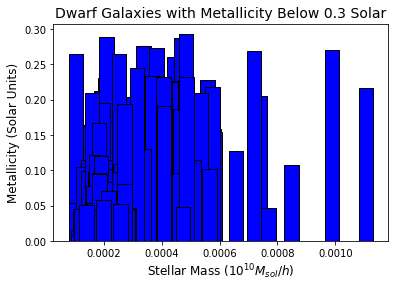

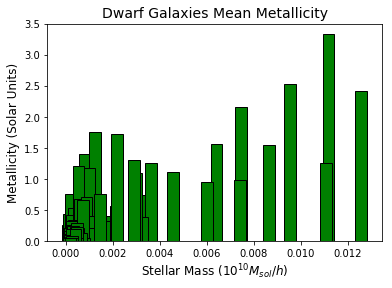

In [17]:
# This plots bar graphs of the stellar mass values that correspond to certain metallicities

plt.figure(1)
plt.bar(stellarmasscut,Z_cut,0.00005,color='blue',edgecolor='black')
plt.title('Dwarf Galaxies with Metallicity Below 0.3 Solar',fontsize=14)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 12)
plt.ylabel('Metallicity (Solar Units)',fontsize = 12)

plt.figure(2)
plt.bar(stellarmass,Z_dwarf,0.0005,color='green',edgecolor='black')
plt.title('Dwarf Galaxies Mean Metallicity',fontsize=14)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 12)
plt.ylabel('Metallicity (Solar Units)',fontsize = 12)

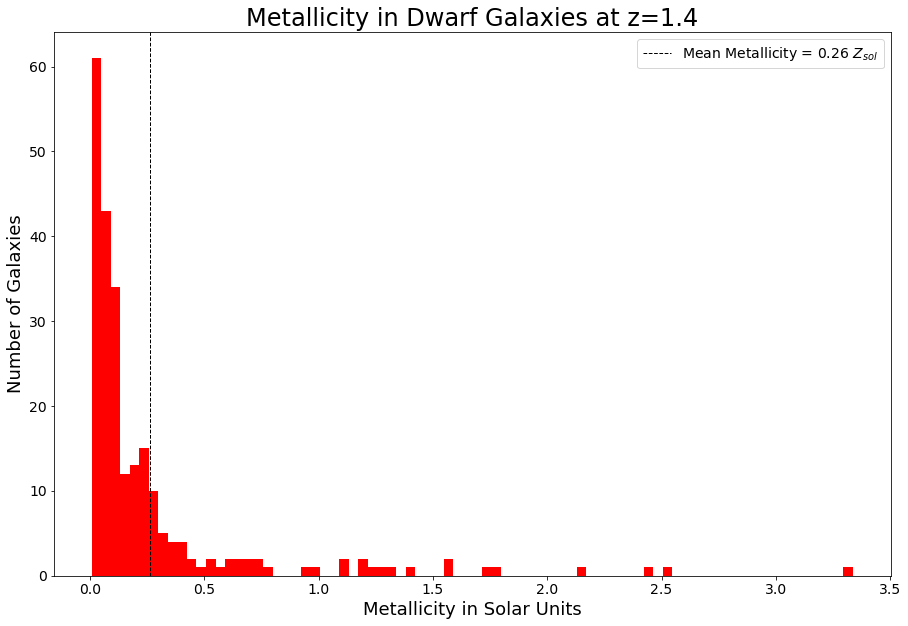

In [18]:
# This plots the metallicity in dwarf galaxies for all of the galaxies at a given redshift

plt.figure(figsize=(15,10))
plt.hist(Z_dwarf,color='red',bins=80)
plt.title('Metallicity in Dwarf Galaxies at z=1.4',fontsize = 24)
plt.xlabel('Metallicity in Solar Units',fontsize=18)
plt.xticks(numpy.arange(0,4,0.5),fontsize=14)
plt.axvline(x=0.26364459196025647,linewidth=1, color='k', linestyle='--',label='Mean Metallicity = 0.26 $Z_{sol}$')
plt.yticks(fontsize=14)
#plt.xlim(xmin=0,xmax=1)
plt.ylabel('Number of Galaxies',fontsize=18)
plt.legend(fontsize=14)

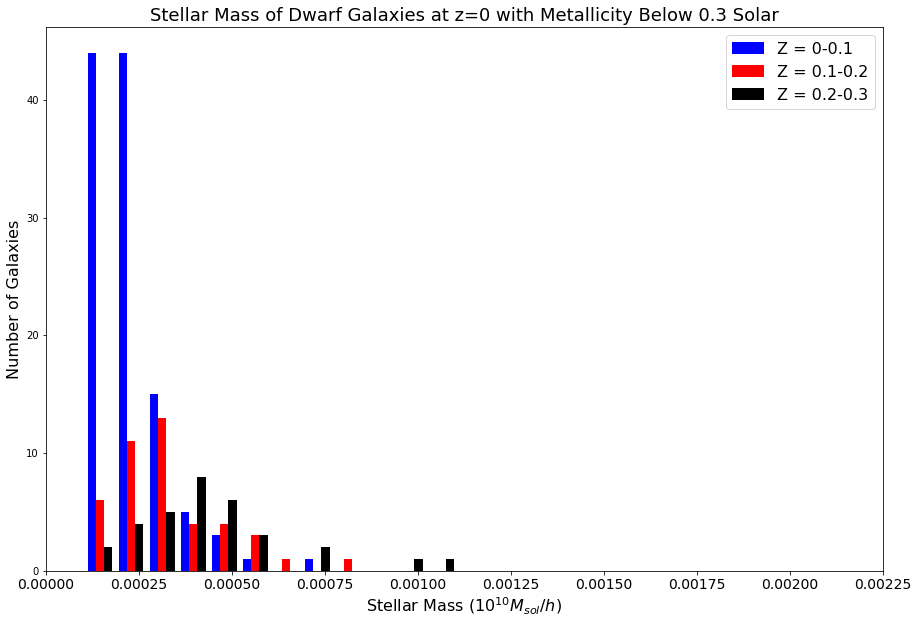

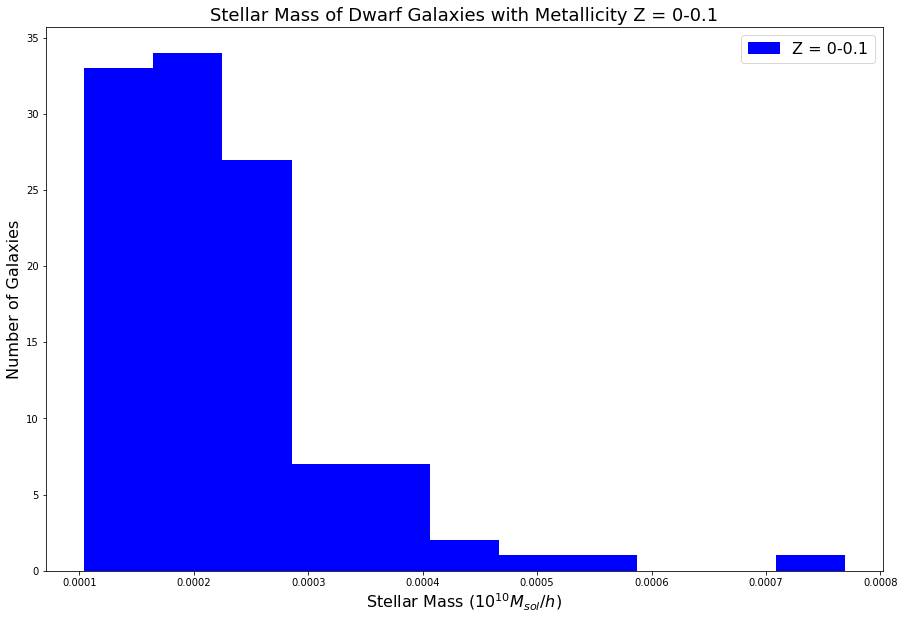

In [19]:
# This plots histograms of the stellar mass values that correspond to metallicity values below 0.3 solar

Z_0_1 = []
Z_1_2 = []
Z_2_3 = []
entry01 = []
entry12 = []
entry23 = []


# This loops over the metallicities and creates arrays with certain metallicity ranges
# It also stores the index values in separate arrays
# EX: Z_0_1 means metallicities with values of 0-0.1 solar
for i in range(0,len(Z_dwarf)):
    if Z_dwarf[i]>=0 and Z_dwarf[i]<=0.1:
        Z_0_1.append(Z_dwarf[i])
        entry01.append(i)
    if Z_dwarf[i]>=0.1 and Z_dwarf[i]<=0.2:
        Z_1_2.append(Z_dwarf[i])
        entry12.append(i)
    if Z_dwarf[i]>=0.2 and Z_dwarf[i]<=0.3:
        Z_2_3.append(Z_dwarf[i])
        entry23.append(i)
        
        
stellarmass01 = []
stellarmass12 = []
stellarmass23 = []

# This appends stellar mass values that correpond to the metallicity ranges
for j in entry01:
    stellarmass01.append(stellarmass[j])
for k in entry12:
    stellarmass12.append(stellarmass[k])
for l in entry23:
    stellarmass23.append(stellarmass[l])
    

colors = ['blue', 'red', 'black']
names = ['Z = 0-0.1', 'Z = 0.1-0.2', 'Z = 0.2-0.3']

# This plots all three metallicity ranges
   
plt.figure(figsize=(15,10))
plt.hist([stellarmass01, stellarmass12, stellarmass23], bins = 12, color = colors, label=names)
plt.xticks(numpy.arange(0,0.0025,0.00025),fontsize=14)
#plt.yticks(numpy.arange(0,10,1),fontsize=14)
plt.title('Stellar Mass of Dwarf Galaxies at z=0 with Metallicity Below 0.3 Solar',fontsize=18)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
plt.ylabel('Number of Galaxies',fontsize = 16)
plt.legend(prop={'size': 16})


# This plots metallicity ranges from 0-0.1 solar 

plt.figure(figsize=(15,10))
plt.hist(stellarmass01, bins = 11, color = colors[0], label=names[0])
#plt.xticks(numpy.arange(0,0.1,0.025),fontsize=14)
#plt.yticks(numpy.arange(0,6,1),fontsize=14)
plt.title('Stellar Mass of Dwarf Galaxies with Metallicity Z = 0-0.1',fontsize=18)
plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
plt.ylabel('Number of Galaxies',fontsize = 16)
plt.legend(prop={'size': 16})

# This plots metallicity ranges form 0.1-0.2 solar

# plt.figure(figsize=(15,10))
# plt.hist(stellarmass12, bins = 7, color = colors[1], label=names[1])
# #plt.xticks(numpy.arange(0.1,0.2,0.025),fontsize=14)
# #plt.yticks(numpy.arange(0,10,1),fontsize=14)
# plt.title('Stellar Mass of Dwarf Galaxies with Metallicity Z = 0.1-0.2',fontsize=18)
# plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
# plt.ylabel('Number of Galaxies',fontsize = 16)
# plt.legend(prop={'size': 16})

# This plots metallicity ranges from 0.2-0.3 solar

# plt.figure(figsize=(15,10))
# plt.hist(stellarmass23, bins = 9, color = colors[2], label=names[2])
# #plt.xticks(numpy.arange(0.2,0.3,0.025),fontsize=14)
# #plt.yticks(numpy.arange(0,8,1),fontsize=14)
# plt.title('Stellar Mass of Dwarf Galaxies with Metallicity Z = 0.2-0.3',fontsize=18)
# plt.xlabel(r'Stellar Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
# plt.ylabel('Number of Galaxies',fontsize = 16)
# plt.legend(prop={'size': 16})

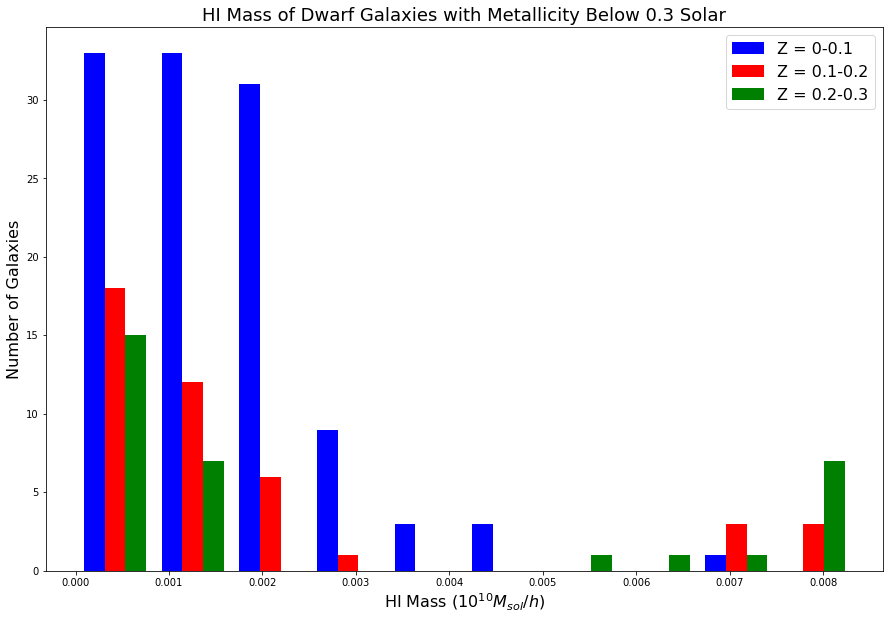

In [20]:
# This plots the HI masses for galaxies that have metallicity values below 0.3 solar

adjusted_HI_mass = []
for i in entry1:
    adjusted_HI_mass.append(hi_mass[i])

HImass01 = []
HImass12 = []
HImass23 = []


for j in entry01:
    HImass01.append(hi_mass[j])
for k in entry12:
    HImass12.append(hi_mass[k])
for l in entry23:
    HImass23.append(hi_mass[l])

#print(HImass01)
colors = ['blue', 'red', 'green']
names = ['Z = 0-0.1', 'Z = 0.1-0.2', 'Z = 0.2-0.3']
   
plt.figure(figsize=(15,10))
plt.hist([HImass01, HImass12, HImass23], bins = 10, color = colors, label=names)
#plt.xticks(numpy.arange(0,0.35,0.025),fontsize=14)
plt.title('HI Mass of Dwarf Galaxies with Metallicity Below 0.3 Solar',fontsize=18)
plt.xlabel(r'HI Mass ($10^{10} M_{sol}/h$)',fontsize = 16)
plt.ylabel('Number of Galaxies',fontsize = 16)
plt.legend(prop={'size': 16})

In [21]:
# These functions are taken from master.py script
# The only change made is the value of h to equal 0.704

def phistar(z) :
    phi0 = 0.0035
    phi1 = -2.2
    return phi0*(1+z)**phi1

def fracM(M, z) :
    M0 = 11.16
    M1 = 0.17
    M2 = -0.07

    hatM = 1e1**(M0 + M1*z + M2*z*z)
    return M/hatM

def phi(M,z=0.) :
    alpha0 = -1.18
    alpha1 = -0.082
    alpha = alpha0 + alpha1*z
    return math.log(10.) * phistar(z)*fracM(M,z)**(1.+alpha) * numpy.exp( -fracM(M,z))

def PanterZ(lgMstar) :

    logMc = 9.66
    Delta = 1.04
    A = -0.452
    B = 0.572
    out = numpy.tanh((lgMstar - logMc)/Delta)
    arg = A + B*out
    return 10**arg

def lamfit(Ptless,Zint):
# will return interpolated fit for lambda (fitting to O17 and Lamberts et al. 2016) given Z_HI or Z_dwarf (Zint) -- 
    Z = numpy.arange(0.001,1.,0.01)
    a = 3.9007870e-09
    b = 1.4792985e-07
    lamfit = a*((1./Z)**3) +b
    lamfit = lamfit/Ptless
    int = numpy.interp(Zint,Z,lamfit)
    ## now impose floor:
    lamint = numpy.minimum(int,1.5e-4*1.e1)
    print ("lamint=" + str(lamint))
    return lamint

def Richlambda(Zint):
# will read in file form Richard and return interpolated lambda values at Zint    
    #filename = "dat_lambda_factor.txt"  # old file don't use                     
    filename = "dat_lambda_M40cut.txt" # should have mass cut > 40 Msun           
    #filename = "dat_lambda.txt" # new file but doesn't have mass cut      

    data = loadtxt(filename,
              dtype=([('Z', 'float'), ('lambda', 'float'), ('av_mc', 'float'), ('V', 'float')]))

    lam = data["lambda"]/1.e-3
    Z = data["Z"]/0.0134

    lamint = numpy.interp(Zint,Z,lam)
    print ("lamint=" + str(lamint))
    return lamint

def TremontiZ(lgMstar, corr = 0.):
    lgZ = -1.492 + 1.847*lgMstar - 0.08026*(lgMstar**2) - 8.69 +corr
    return 10**lgZ

def AM13Z(lgMstar,OHasym,Mto,gamma):
    Mstar = 10**lgMstar
    lgZ = OHasym - numpy.log10(1.+(Mto/Mstar)**gamma) - 8.69
    return 10**lgZ

def LeeZ(lgMstar):
    lgZ = 5.65 + 0.298*lgMstar - 8.66
    return 10**lgZ

def mratedwarfZLee(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZLee,dlgM,Mhdwarf,Phi_dwarf):
    #lmbda = lamfit(Ptless,Zdwarf)
    lmbda = Richlambda(Zdwarf)
    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)                                          
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()


def mratedwarfZP(Mstar,SFRdwarf,Zdwarf,Ptless,dt,Zp,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zp) # leads to weird plot
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()

def mratedwarfZAM13(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZAM13,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZAM13)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()

def mratedwarfZTrem(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZTrem,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZTrem)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum()

def mratedwarfZdwarf(Mstar,SFRdwarf,Zdwarf,Ptless,dt,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zdwarf)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    #print "N_dwarf = " + str(Ndwarf)
    return (Zdwarf*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf).sum(), lmbda

def detectrdwarfZp(Mstar,SFRdwarf,Zdwarf,Ptless,dt,Zp,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zp)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/Zp)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZdwarf(Mstar,SFRdwarf,Zdwarf,Ptless,dt,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,Zdwarf)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/Zdwarf)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZAm13(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZAM13,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZAM13)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/ZAM13)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZTrem(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZTrem,dlgM,Mhdwarf,Phi_dwarf) :

#    lmbda = lamfit(Ptless,ZTrem)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/ZTrem)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)

def detectrdwarfZLee(Mstar,SFRdwarf,Zdwarf,Ptless,dt,ZLee,dlgM,Mhdwarf,Phi_dwarf) :
#    lmbda = lamfit(Ptless,ZLee)
    lmbda = Richlambda(Zdwarf)
#    lmbda = lamfit(Ptless,Zdwarf)

    Ndwarf = SFRdwarf*(1./Zdwarf)*lmbda*Ptless*dt
    return ((Zdwarf/ZLee)*Phi_dwarf*dlgM*(Mstar/Mhdwarf)*Ndwarf)


In [22]:
####--------Set parameters and return merger rate, detection rate, and plots --------

ZHI = 0.35
print ("Z_HI=" + str(ZHI))

M51 = 3.98e10  ## from Leroy et al. 2008                                        

SFRM51 = 0.1 ## Bigiel et al. 2010, C11
ZM51 = 0.1  # C11
dt = 10.e9  # Bigiel et al. 2010 - depletion time
                                                 
Ptless = 1.e-3  # the fraction of black holes that merge within Hubble time

dlgM = 0.1
lgMstar = numpy.arange(5, 9.89, dlgM)
Mstar =1e1**lgMstar

Phi_dwarf = phi(Mstar,z=0)
print(Phi_dwarf)
ZTrem = TremontiZ(lgMstar,corr=-0.26)
ZPanter = PanterZ(lgMstar)
ZLee = LeeZ(lgMstar)

## from Andrews & Martini 2013:
#Mto = 10**32.65
#OHasym = 16.988
#gamma = 0.373
### first row for MZR in Table 4:
#Mto = 10**8.901
#OHasym = 8.798
#gamma = 0.64
### second row:
Mto = 8.253
OHasym = 8.726
gamma = 0.734
ZAM13 = AM13Z(lgMstar,OHasym,Mto,gamma)

###----------dwarf galaxy parameters ---------------

print ("------dwarfs---------")

Mhdwarf = 2.5e8  ## from O17 h516
SFRdwarf = 0.01
Zdwarf = 0.1
## the bigger one h603
# Mhdwarf = 7.8e9
# SFRdwarf = 1.
# Zdwarf = 0.4

Z_HI=0.35
[0.1035341  0.09933067 0.09529788 0.09142882 0.08771684 0.08415555
 0.08073885 0.07746084 0.07431592 0.07129866 0.06840388 0.06562661
 0.06296207 0.06040567 0.05795304 0.05559993 0.0533423  0.05117628
 0.04909811 0.04710423 0.04519118 0.04335567 0.04159452 0.03990468
 0.0382832  0.03672728 0.03523418 0.03380128 0.03242606 0.03110606
 0.02983893 0.02862236 0.02745412 0.02633202 0.02525393 0.02421774
 0.02322136 0.0222627  0.02133968 0.02045018 0.01959202 0.01876295
 0.01796064 0.0171826  0.01642618 0.01568854 0.01496657 0.0142569
 0.01355583]
------dwarfs---------


In [23]:
# Obtaining all needed information from all_data array

StellarMass = []
converted_stellar_mass = []
HImass = []
VirialMass = []
Metallicity = []
StarFormation= []
HaloID = []
LHAT = []

for i in range(1,len(all_data)):
    StellarMass.append(all_data[i][1])
    converted_stellar_mass.append(all_data[i][1]*1e10*0.704)
    HImass.append(all_data[i][5])
    VirialMass.append(all_data[i][3])
    Metallicity.append(all_data[i][7])
    StarFormation.append(all_data[i][8])
    HaloID.append(all_data[i][0])
    LHAT.append(all_data[i][6])

In [24]:
# This loops over all galaxies in the all_data array and calculates the merger rates and detection rates below
# It stores the merger rate and detection rate of Zdwarf as well as lambda into an array

MRATEDDWARFZDWARF = []
DRATEDDWARFZDWARF = []
DRATEDDWARFZLEE = []
DRATEDDWARFZP = []
DRATEDDWARFZAM13 = []
DRATEDDWARFZTREM = []
LAMBDA = []

for i in range(0,len(Metallicity)):
    
    print('---------------------------------HALO  '+str(HaloID[i])+'----------------------------------------')

    MratedwarfZP= mratedwarfZP(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZPanter,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w Panter = " + str(MratedwarfZP*1e3**3/dt)) # conversion to Gpc-3 and rate                                                                  
    print('')
    #MRATEDDWARFZP.append(MratedwarfZP*1e3**3/dt)
    
    MratedwarfZAM13= mratedwarfZAM13(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZAM13,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w AM13 = " + str(MratedwarfZAM13*1e3**3/dt)) 
    print('')
    
    MratedwarfZTrem= mratedwarfZTrem(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZTrem,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w Tremonti = " + str(MratedwarfZTrem*1e3**3/dt))
    print('')
    
    DratedwarfZP = detectrdwarfZp(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZPanter,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Panter = " + str(DratedwarfZP.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZP.append(DratedwarfZP.sum()*1e3**3/dt)
    
    MratedwarfZdwarf, Lambda = mratedwarfZdwarf(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("merger rate dwarfs per cubic Gpc w Zdwarf = " + str(MratedwarfZdwarf*1e3**3/dt)) 
    print('')
    MRATEDDWARFZDWARF.append(MratedwarfZdwarf*1e3**3/dt)
    LAMBDA.append(Lambda)
    
    
    DratedwarfZdwarf = detectrdwarfZdwarf(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Zdwarf = " + str(DratedwarfZdwarf.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZDWARF.append(DratedwarfZdwarf.sum()*1e3**3/dt)
    
    DratedwarfZAM13 = detectrdwarfZAm13(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZAM13,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with AM13 = " + str(DratedwarfZAM13.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZAM13.append(DratedwarfZAM13.sum()*1e3**3/dt)
    
    DratedwarfZTrem = detectrdwarfZTrem(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZTrem,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Tremonti = " + str(DratedwarfZTrem.sum()*1e3**3/dt))
    print('')
    DRATEDDWARFZTREM.append(DratedwarfZTrem.sum()*1e3**3/dt)
    
    DratedwarfZLee = detectrdwarfZLee(Mstar,StarFormation[i],Metallicity[i],Ptless,dt,ZLee,dlgM,converted_stellar_mass[i],Phi_dwarf)
    print ("detection rate dwarfs per cubic Gpc with Lee = " + str(DratedwarfZLee.sum()*1e3**3/dt))
    DRATEDDWARFZLEE.append(DratedwarfZLee.sum()*1e3**3/dt)
    print('')
    print('')
    print('')
    print('')
    
    

---------------------------------HALO  57813----------------------------------------
lamint=0.00036813819008524616
merger rate dwarfs per cubic Gpc w Panter = 220.93572657442544

lamint=0.00036813819008524616
merger rate dwarfs per cubic Gpc w AM13 = 220.93572657442544

lamint=0.00036813819008524616
merger rate dwarfs per cubic Gpc w Tremonti = 220.93572657442544

lamint=0.00036813819008524616
detection rate dwarfs per cubic Gpc with Panter = 959.1961094349675

lamint=0.00036813819008524616
merger rate dwarfs per cubic Gpc w Zdwarf = 220.93572657442544

lamint=0.00036813819008524616
detection rate dwarfs per cubic Gpc with Zdwarf = 1346.9110160384234

lamint=0.00036813819008524616
detection rate dwarfs per cubic Gpc with AM13 = 203.36053459366758

lamint=0.00036813819008524616
detection rate dwarfs per cubic Gpc with Tremonti = 545.5816438215104

lamint=0.00036813819008524616
detection rate dwarfs per cubic Gpc with Lee = 413.5974419140328




---------------------------------HALO  105

lamint=0.0
merger rate dwarfs per cubic Gpc w Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w AM13 = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with AM13 = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Lee = 0.0




---------------------------------HALO  105413----------------------------------------
lamint=0.0
merger rate dwarfs per cubic Gpc w Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w AM13 = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per c

lamint=0.00023865960787693963
detection rate dwarfs per cubic Gpc with Zdwarf = 14.162801799279654

lamint=0.00023865960787693963
detection rate dwarfs per cubic Gpc with AM13 = 5.024234172735744

lamint=0.00023865960787693963
detection rate dwarfs per cubic Gpc with Tremonti = 13.479163714741379

lamint=0.00023865960787693963
detection rate dwarfs per cubic Gpc with Lee = 10.218356307789117




---------------------------------HALO  576027----------------------------------------
lamint=0.0004262527264633881
merger rate dwarfs per cubic Gpc w Panter = 13.755205013209716

lamint=0.0004262527264633881
merger rate dwarfs per cubic Gpc w AM13 = 13.755205013209716

lamint=0.0004262527264633881
merger rate dwarfs per cubic Gpc w Tremonti = 13.755205013209716

lamint=0.0004262527264633881
detection rate dwarfs per cubic Gpc with Panter = 59.71844996606537

lamint=0.0004262527264633881
merger rate dwarfs per cubic Gpc w Zdwarf = 13.755205013209716

lamint=0.0004262527264633881
detection rate d

lamint=0.0004907467417652458
detection rate dwarfs per cubic Gpc with Tremonti = 20.658637202430256

lamint=0.0004907467417652458
detection rate dwarfs per cubic Gpc with Lee = 15.661009854559094




---------------------------------HALO  622593----------------------------------------
lamint=0.00042738828428415243
merger rate dwarfs per cubic Gpc w Panter = 31.69732032840868

lamint=0.00042738828428415243
merger rate dwarfs per cubic Gpc w AM13 = 31.69732032840868

lamint=0.00042738828428415243
merger rate dwarfs per cubic Gpc w Tremonti = 31.69732032840868

lamint=0.00042738828428415243
detection rate dwarfs per cubic Gpc with Panter = 137.61444022626873

lamint=0.00042738828428415243
merger rate dwarfs per cubic Gpc w Zdwarf = 31.69732032840868

lamint=0.00042738828428415243
detection rate dwarfs per cubic Gpc with Zdwarf = 852.2148120037662

lamint=0.00042738828428415243
detection rate dwarfs per cubic Gpc with AM13 = 29.175833655859606

lamint=0.00042738828428415243
detection rate 

lamint=0.00041578582207628406
merger rate dwarfs per cubic Gpc w Zdwarf = 11.562328821002046

lamint=0.00041578582207628406
detection rate dwarfs per cubic Gpc with Zdwarf = 232.33549571477687

lamint=0.00041578582207628406
detection rate dwarfs per cubic Gpc with AM13 = 10.642558388557724

lamint=0.00041578582207628406
detection rate dwarfs per cubic Gpc with Tremonti = 28.552169729969478

lamint=0.00041578582207628406
detection rate dwarfs per cubic Gpc with Lee = 21.64498108604633




---------------------------------HALO  450749----------------------------------------
lamint=0.0004338650903693984
merger rate dwarfs per cubic Gpc w Panter = 6.525274644512444

lamint=0.0004338650903693984
merger rate dwarfs per cubic Gpc w AM13 = 6.525274644512444

lamint=0.0004338650903693984
merger rate dwarfs per cubic Gpc w Tremonti = 6.525274644512444

lamint=0.0004338650903693984
detection rate dwarfs per cubic Gpc with Panter = 28.329587745070008

lamint=0.0004338650903693984
merger rate dwarf


lamint=0.0004018524342404367
merger rate dwarfs per cubic Gpc w Zdwarf = 11.380186772412982

lamint=0.0004018524342404367
detection rate dwarfs per cubic Gpc with Zdwarf = 174.26333257095118

lamint=0.0004018524342404367
detection rate dwarfs per cubic Gpc with AM13 = 10.474905537896738

lamint=0.0004018524342404367
detection rate dwarfs per cubic Gpc with Tremonti = 28.102385714414325

lamint=0.0004018524342404367
detection rate dwarfs per cubic Gpc with Lee = 21.30400642101839




---------------------------------HALO  391353----------------------------------------
lamint=0.0003971165147103822
merger rate dwarfs per cubic Gpc w Panter = 73.54331695468109

lamint=0.0003971165147103822
merger rate dwarfs per cubic Gpc w AM13 = 73.54331695468109

lamint=0.0003971165147103822
merger rate dwarfs per cubic Gpc w Tremonti = 73.54331695468109

lamint=0.0003971165147103822
detection rate dwarfs per cubic Gpc with Panter = 319.289526377752

lamint=0.0003971165147103822
merger rate dwarfs per 


lamint=0.0
detection rate dwarfs per cubic Gpc with Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with AM13 = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Lee = 0.0




---------------------------------HALO  296287----------------------------------------
lamint=0.0
merger rate dwarfs per cubic Gpc w Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w AM13 = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with AM13 = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Lee = 0.0




---------------------------------HALO  309830----------------------------------

lamint=0.00040024759424284135
detection rate dwarfs per cubic Gpc with AM13 = 13.525366105157651

lamint=0.00040024759424284135
detection rate dwarfs per cubic Gpc with Tremonti = 36.286251350017

lamint=0.00040024759424284135
detection rate dwarfs per cubic Gpc with Lee = 27.508074923295172




---------------------------------HALO  515198----------------------------------------
lamint=0.00045736061346448074
merger rate dwarfs per cubic Gpc w Panter = 60.47528082043296

lamint=0.00045736061346448074
merger rate dwarfs per cubic Gpc w AM13 = 60.47528082043296

lamint=0.00045736061346448074
merger rate dwarfs per cubic Gpc w Tremonti = 60.47528082043296

lamint=0.00045736061346448074
detection rate dwarfs per cubic Gpc with Panter = 262.55443145998254

lamint=0.00045736061346448074
merger rate dwarfs per cubic Gpc w Zdwarf = 60.47528082043296

lamint=0.00045736061346448074
detection rate dwarfs per cubic Gpc with Zdwarf = 1855.9495472680446

lamint=0.00045736061346448074
detection rate 

lamint=0.0002982666858316937
detection rate dwarfs per cubic Gpc with Tremonti = 3.4818512693728234

lamint=0.0002982666858316937
detection rate dwarfs per cubic Gpc with Lee = 2.6395403775880304




---------------------------------HALO  211201----------------------------------------
lamint=0.0003365497195626233
merger rate dwarfs per cubic Gpc w Panter = 7.693007732096788

lamint=0.0003365497195626233
merger rate dwarfs per cubic Gpc w AM13 = 7.693007732096788

lamint=0.0003365497195626233
merger rate dwarfs per cubic Gpc w Tremonti = 7.693007732096788

lamint=0.0003365497195626233
detection rate dwarfs per cubic Gpc with Panter = 33.399320249794926

lamint=0.0003365497195626233
merger rate dwarfs per cubic Gpc w Zdwarf = 7.693007732096788

lamint=0.0003365497195626233
detection rate dwarfs per cubic Gpc with Zdwarf = 33.20817321732135

lamint=0.0003365497195626233
detection rate dwarfs per cubic Gpc with AM13 = 7.081037500313069

lamint=0.0003365497195626233
detection rate dwarfs pe

detection rate dwarfs per cubic Gpc with Lee = 10.712383411328242




---------------------------------HALO  503829----------------------------------------
lamint=0.00029944930700546426
merger rate dwarfs per cubic Gpc w Panter = 18.88299643835503

lamint=0.00029944930700546426
merger rate dwarfs per cubic Gpc w AM13 = 18.88299643835503

lamint=0.00029944930700546426
merger rate dwarfs per cubic Gpc w Tremonti = 18.88299643835503

lamint=0.00029944930700546426
detection rate dwarfs per cubic Gpc with Panter = 81.98084121104351

lamint=0.00029944930700546426
merger rate dwarfs per cubic Gpc w Zdwarf = 18.88299643835503

lamint=0.00029944930700546426
detection rate dwarfs per cubic Gpc with Zdwarf = 57.64619352296073

lamint=0.00029944930700546426
detection rate dwarfs per cubic Gpc with AM13 = 17.380875017244534

lamint=0.00029944930700546426
detection rate dwarfs per cubic Gpc with Tremonti = 46.62992444385409

lamint=0.00029944930700546426
detection rate dwarfs per cubic Gpc with Lee 



---------------------------------HALO  761155----------------------------------------
lamint=0.0007625997692052472
merger rate dwarfs per cubic Gpc w Panter = 100.87827687916867

lamint=0.0007625997692052472
merger rate dwarfs per cubic Gpc w AM13 = 100.87827687916867

lamint=0.0007625997692052472
merger rate dwarfs per cubic Gpc w Tremonti = 100.87827687916867

lamint=0.0007625997692052472
detection rate dwarfs per cubic Gpc with Panter = 437.9647067918022

lamint=0.0007625997692052472
merger rate dwarfs per cubic Gpc w Zdwarf = 100.87827687916867

lamint=0.0007625997692052472
detection rate dwarfs per cubic Gpc with Zdwarf = 8052.622397813736

lamint=0.0007625997692052472
detection rate dwarfs per cubic Gpc with AM13 = 92.85352185050566

lamint=0.0007625997692052472
detection rate dwarfs per cubic Gpc with Tremonti = 249.1101687308058

lamint=0.0007625997692052472
detection rate dwarfs per cubic Gpc with Lee = 188.84676511503298




---------------------------------HALO  87619-----

merger rate dwarfs per cubic Gpc w Panter = 64.31100964780877

lamint=0.0008763304891580346
merger rate dwarfs per cubic Gpc w AM13 = 64.31100964780877

lamint=0.0008763304891580346
merger rate dwarfs per cubic Gpc w Tremonti = 64.31100964780877

lamint=0.0008763304891580346
detection rate dwarfs per cubic Gpc with Panter = 279.2073115763499

lamint=0.0008763304891580346
merger rate dwarfs per cubic Gpc w Zdwarf = 64.31100964780877

lamint=0.0008763304891580346
detection rate dwarfs per cubic Gpc with Zdwarf = 5638.856313728447

lamint=0.0008763304891580346
detection rate dwarfs per cubic Gpc with AM13 = 59.19514016594

lamint=0.0008763304891580346
detection rate dwarfs per cubic Gpc with Tremonti = 158.81046901508253

lamint=0.0008763304891580346
detection rate dwarfs per cubic Gpc with Lee = 120.39188722283073




---------------------------------HALO  824255----------------------------------------
lamint=0.0005467329233261205
merger rate dwarfs per cubic Gpc w Panter = 60.6057769352

merger rate dwarfs per cubic Gpc w AM13 = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Panter = 0.0

lamint=0.0
merger rate dwarfs per cubic Gpc w Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Zdwarf = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with AM13 = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Tremonti = 0.0

lamint=0.0
detection rate dwarfs per cubic Gpc with Lee = 0.0




---------------------------------HALO  432073----------------------------------------
lamint=0.00033486180720546484
merger rate dwarfs per cubic Gpc w Panter = 18.000584713220334

lamint=0.00033486180720546484
merger rate dwarfs per cubic Gpc w AM13 = 18.000584713220334

lamint=0.00033486180720546484
merger rate dwarfs per cubic Gpc w Tremonti = 18.000584713220334

lamint=0.00033486180720546484
detection rate dwarfs per cubic Gpc with Panter = 78.14983611832994

lamint=0.00033486180720546484
merg


lamint=0.00042373233053989067
detection rate dwarfs per cubic Gpc with Panter = 131.04741367459766

lamint=0.00042373233053989067
merger rate dwarfs per cubic Gpc w Zdwarf = 30.184709123718047

lamint=0.00042373233053989067
detection rate dwarfs per cubic Gpc with Zdwarf = 640.8746536826934

lamint=0.00042373233053989067
detection rate dwarfs per cubic Gpc with AM13 = 27.783548994670433

lamint=0.00042373233053989067
detection rate dwarfs per cubic Gpc with Tremonti = 74.53852519612612

lamint=0.00042373233053989067
detection rate dwarfs per cubic Gpc with Lee = 56.50656266442915




---------------------------------HALO  802684----------------------------------------
lamint=0.00048278639804327864
merger rate dwarfs per cubic Gpc w Panter = 13.347334792944446

lamint=0.00048278639804327864
merger rate dwarfs per cubic Gpc w AM13 = 13.347334792944446

lamint=0.00048278639804327864
merger rate dwarfs per cubic Gpc w Tremonti = 13.347334792944446

lamint=0.00048278639804327864
detection 


lamint=0.00040354466591693947
merger rate dwarfs per cubic Gpc w Zdwarf = 59.29950909960036

lamint=0.00040354466591693947
detection rate dwarfs per cubic Gpc with Zdwarf = 844.5257770427845

lamint=0.00040354466591693947
detection rate dwarfs per cubic Gpc with AM13 = 54.58229892744157

lamint=0.00040354466591693947
detection rate dwarfs per cubic Gpc with Tremonti = 146.43500240541715

lamint=0.00040354466591693947
detection rate dwarfs per cubic Gpc with Lee = 111.0102275020271




---------------------------------HALO  540578----------------------------------------
lamint=0.00041349232722535494
merger rate dwarfs per cubic Gpc w Panter = 50.64804043875332

lamint=0.00041349232722535494
merger rate dwarfs per cubic Gpc w AM13 = 50.64804043875332

lamint=0.00041349232722535494
merger rate dwarfs per cubic Gpc w Tremonti = 50.64804043875332

lamint=0.00041349232722535494
detection rate dwarfs per cubic Gpc with Panter = 219.8893048788637

lamint=0.00041349232722535494
merger rate dwa

In [25]:
# This creates a text file of all merger rate and detection rate values for dwarves at this redshift

with open("dwarf_merger_rate_z=1.4.txt", "w") as myfile:
    for i in range(0,len(Metallicity)):
        ids = HaloID[i],VirialMass[i],StellarMass[i],HImass[i], Metallicity[i], StarFormation[i], MRATEDDWARFZDWARF[i], DRATEDDWARFZDWARF[i]
        myfile.write(str(ids)+'\n')

In [26]:
# This finds the merger rate and detection rate of galaxies that have metallicities below 0.3 solar
# It creates arrays for the merger rate, detection rate, and index value that these galaxies reside in

merger_rate_lowz = []
detection_rate_lowz = []
detect_LEE = []
detect_ZP = []
detect_ZAM13 = []
detect_Ztrem = []
sfr_lowz = []
entry2 = []

for i in range(0,len(MRATEDDWARFZDWARF)):
    if Metallicity[i]<=0.3:
        merger_rate_lowz.append(MRATEDDWARFZDWARF[i])
        detection_rate_lowz.append(DRATEDDWARFZDWARF[i])
        detect_LEE.append(DRATEDDWARFZLEE[i])
        detect_ZP.append(DRATEDDWARFZP[i])
        detect_ZAM13.append(DRATEDDWARFZAM13[i])
        detect_Ztrem.append(DRATEDDWARFZTREM[i])
        sfr_lowz.append(StarFormation[i])
        entry2.append(i)

newHaloID = []
newVirialMass = []
newStellarMass = []
newHImass = []
newMetallicity = []
newStarFormation = []
newMRATEDDWARFZDWARF = []
newDRATEDDWARFZDWARF = []
newLAMBDA = []

HaloID = numpy.array(HaloID)
VirialMass = numpy.array(VirialMass)
StellarMass = numpy.array(StellarMass)
HImass = numpy.array(HImass)
Metallicity = numpy.array(Metallicity)
StarFormation = numpy.array(StarFormation)
MRATEDDWARFZDWARF = numpy.array(MRATEDDWARFZDWARF)
DRATEDDWARFZDWARF = numpy.array(DRATEDDWARFZDWARF)
LAMBDA = numpy.array(LAMBDA)

# This loops over the indices that include galaxies with metallicities below 0.3 solar and extracts the following information and stores them into new arrays
for i in entry2:
    newHaloID.append(HaloID[i])
    newVirialMass.append(VirialMass[i])
    newStellarMass.append(StellarMass[i])
    newHImass.append(HImass[i])
    newMetallicity.append(Metallicity[i])
    newStarFormation.append(StarFormation[i])
    newMRATEDDWARFZDWARF.append(MRATEDDWARFZDWARF[i]) 
    newDRATEDDWARFZDWARF.append(DRATEDDWARFZDWARF[i])
    newLAMBDA.append(LAMBDA[i])
    
    
#print(newHaloID)
    
print(numpy.max(detection_rate_lowz))
        
print(numpy.mean(merger_rate_lowz))
print('')
print(numpy.mean(detection_rate_lowz))
print('')
print('Zdwarf :',numpy.sum(detection_rate_lowz))
print('')
print('Lee: ',numpy.sum(detect_LEE))
print('')
print('ZP: ', numpy.sum(detect_ZP))
print('')
print('ZAM13: ',numpy.sum(detect_ZAM13))
print('')
print('Ztrem: ', numpy.sum(detect_Ztrem))
print(numpy.mean(sfr_lowz))
    
    


37244.5826053835
31.043276341960286

789.9335035524751

Zdwarf : 148507.49866786532

Lee:  10925.398702848215

ZP:  25337.68071993071

ZAM13:  5371.877810893185

Ztrem:  14411.832326913354
0.0026935088598936167


In [ ]:
def density_weighted_average(halo_ids,Lhat):

    final = []

    for a in range(0,len(halo_ids)):

        f = h5py.File('/Users/sandyspicer/Desktop/RIT/Illustris-3/groups_135/illustris_api/dwarf/cutout_'+str(halo_ids[a])+'.hdf5', 'r')

        xyz = numpy.array([0,1,2], dtype=numpy.int32)
        newxyz = [xyz for i,xyz in enumerate(xyz) if i!=Lhat[a].argmax()]

        x = f['PartType0']['Coordinates'][:,newxyz[0]]
        y = f['PartType0']['Coordinates'][:,newxyz[1]]

        met = f['PartType0']['GFM_Metallicity'][:]/0.0127
        

        density = f['PartType0']['Density'][:]
        numbins = 100

        xmax = max(x)
        xmin = min(x)
        xstep = (xmax-xmin)/numbins

        ymax = max(y)
        ymin = min(y)
        ystep = (ymax-ymin)/numbins


        pz = numpy.zeros((100,100))
        p = pz.copy()


        # Position of particle - min position divided by step size

        for b in range(0,len(x)):

            i = int((x[b]-xmin)/xstep) - 1
            j = int((y[b]-ymin)/ystep) - 1

            #print(i,j)

            pz[i,j] += density[b]*met[b]

            if density[b]<1e-10:
                print (density[b])

            p[i,j] += density[b]

        p += 1e-17
        #print(p)
        final.append(pz/p)
        
        xtick = range(100)*xstep + xmin
        ytick = range(100)*ystep * ymin
        
        plt.figure()
        plt.imshow(final[a])
        plt.rcParams['figure.facecolor'] = 'white'
        #plt.xticks(numpy.linspace(xmin,xmax,xstep))
        #plt.yticks(numpy.linspace(ymin,ymax,ystep))
        plt.title('Halo '+str(halo_ids[a])+'')
        plt.colorbar()
        
        print('The max metallicity for Halo '+str(halo_ids[a])+' is '+str(max(met)))
        print('The smallest metallicity value being plotted is ' +str(final[a].max()))
        print('')

    #print(final[1])
    
    # draw a line from 10 - 20 using pyplot
    
    # x20 = (20+xstep) + xmin
    # x10 = (10+xstep) + xmin
    # Take the difference (uses as text)

In [ ]:
Lhat = []

# This grabs just the Lhat vector from Ldata
for i in range(1,len(HaloID)):
    Lhat.append(all_data[i][6])

    
Lhat = numpy.array(Lhat)


density_weighted_average(HaloID,Lhat)
#density_weighted_average(halo_ids,Lhat)

In [ ]:
# for i in range(0,len(LHAT)):
#     metallicity_plot('cutout_'+str(HaloID[i])+'.hdf5',LHAT[i]) 

In [ ]:
# # Illustris

# from numpy import mean, size, zeros, where, transpose
# from scipy import linspace
# from matplotlib.pyplot import hist

# log_mstar = []
    
# for j in converted_stellar_mass:
#     LOG_mstar = numpy.log10(j)
#     log_mstar.append(LOG_mstar)
    
# mu = numpy.mean(converted_stellar_mass)
# sigma = numpy.std(converted_stellar_mass)

# x = converted_stellar_mass

# x_max = max(x)
# x_min = min(x)
# N_MIN = 4   #Minimum number of bins (integer)
#             #N_MIN must be more than 1 (N_MIN > 1).
# N_MAX = 50  #Maximum number of bins (integer)
# N = range(N_MIN,N_MAX) # #of Bins
# N = numpy.array(N)
# D = (x_max-x_min)/N    #Bin size vector
# C = numpy.zeros(shape=(size(D),1))

# #Computation of the cost function
# for i in range(size(N)):
#     edges = linspace(x_min,x_max,N[i]+1) # Bin edges
#     ki = hist(x,edges) # Count # of events in bins
#     ki = ki[0]    
#     k = mean(ki) #Mean of event count
#     v = sum((ki-k)**2)/N[i] #Variance of event count
#     C[i] = (2*k-v)/((D[i])**2) #The cost Function

# #Optimal Bin Size Selection

# cmin = min(C)
# idx  = where(C==cmin)
# idx = int(idx[0])
# optD = D[idx]

# edges = linspace(x_min,x_max,N[idx]+1)
# fig = plt.figure(3)

# fig, ax = plt.subplots()

# # Histogram
# n, bins, patches = ax.hist(x,edges)

# # Best fit line
# # y = mlab.normpdf(bins, mu, sigma)
# # ax.plot(bins, y, '--')
# ax.set_xlabel('Stellar Masses')
# ax.set_ylabel('Number of Galaxies')
# plt.title("Illustris Stellar Mass Distribution (Initial Mass Cuts) ($10^{10} M_{sol}/h$)")
# print("The mean is:",mu,'and the standard deviation is:',sigma)

In [ ]:
# mu = numpy.mean(log_mstar)
# sigma = numpy.std(log_mstar)

# x = log_mstar

# x_max = max(x)
# x_min = min(x)
# N_MIN = 4   #Minimum number of bins (integer)
#             #N_MIN must be more than 1 (N_MIN > 1).
# N_MAX = 50  #Maximum number of bins (integer)
# N = range(N_MIN,N_MAX) # #of Bins
# N = numpy.array(N)
# D = (x_max-x_min)/N    #Bin size vector
# C = numpy.zeros(shape=(size(D),1))

# #Computation of the cost function
# for i in range(size(N)):
#     edges = linspace(x_min,x_max,N[i]+1) # Bin edges
#     ki = hist(x,edges) # Count # of events in bins
#     ki = ki[0]    
#     k = mean(ki) #Mean of event count
#     v = sum((ki-k)**2)/N[i] #Variance of event count
#     C[i] = (2*k-v)/((D[i])**2) #The cost Function

# #Optimal Bin Size Selection

# cmin = min(C)
# idx  = where(C==cmin)
# idx = int(idx[0])
# optD = D[idx]

# edges = linspace(x_min,x_max,N[idx]+1)
# fig = plt.figure(3)

# fig, ax = plt.subplots()

# # Histogram
# n, bins, patches = ax.hist(x,edges)

# # Best fit line
# # y = mlab.normpdf(bins, mu, sigma)
# # ax.plot(bins, y, '--')
# ax.set_xlabel(r'$Log(M_{HI}/M_{sol})$')
# ax.set_ylabel('Number of Galaxies')
# #plt.xlim(6,12)
# plt.title("Log Illustris Stellar Mass Distribution (Initial Mass Cuts)")
# print("The mean is:",mu,'and the standard deviation is:',sigma)

In [ ]:
# def phi(M,h):
#     phistar = 4.8e-03/h**3
#     Mstar = 10**(9.96 - 2.0*numpy.log10(h))
#     alpha = -1.33
#     phi = numpy.log(10)*phistar*((M/Mstar)**(alpha+1.))*numpy.exp(-M/Mstar)
#     return phi # not converted yet

In [ ]:
# # Illustris

# converted_stellar_mass = numpy.array(converted_stellar_mass)
# Phi_illustris = phi(converted_stellar_mass,0.704)
# #print(Phi_illustris)

# plt.plot(log_mstar,numpy.log10(Phi_illustris),'bo')
# #plt.xlim(6,11)
# #plt.ylim(-2.5,0)
# plt.xlabel(r'$Log(M_{HI}/M_{sol})$')
# plt.ylabel('Log(phi)')
# plt.title('Illustris Stellar Mass Function')

In [ ]:
# Below are arrays with the mean detection rate, mean merger rate, and mean star formation rate for galaxies with metallicities below 0.3 solar at a given redshift
detection_rates = [282.43375685847843,115.27728469466801,264.4941193707509,294.5644324052239,334.75852546677856,363.73623233633157]
merger_rates = [26.36304464512211,18.522093030572762,23.360624009679054,24.149489938305134,20.96862409877932,25.358807522620875]
redshifts = [0,0.2,0.4,0.6,0.8,1]
sfr_rates = [0.0031839398193939396,0.0016256840131578948,0.0022886582535294117,0.0025390017787931033,0.0018501455359493674,0.0023034516754455443]

redshifts = numpy.array(redshifts)

# This plots the merger rate vs. redshift

# from scipy.interpolate import spline

# xnew = numpy.linspace(redshifts.min(),redshifts.max(),300) #300 represents number of points to make between T.min and T.max

# newmrates = spline(redshifts,merger_rates,xnew)

# plt.plot(xnew,newmrates, 'b')
plt.figure(figsize=(15,10))
plt.plot(redshifts,merger_rates,'bo',markersize=14)
plt.grid()
plt.title('Merger Rate of BBH in Dwarf Galaxies with Metallicity < 0.3',fontsize = 18)
plt.xlabel('Redshift',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Merger Rate ($Gpc^{-3} yr^{-1}$)',fontsize = 16)

# This plots the detection rate vs. redshift
plt.figure(figsize=(15,10))
plt.plot(redshifts,detection_rates,'bo',markersize=14)
plt.grid()
plt.title('Detection Rate of BBH in Dwarf Galaxies with Metallicity < 0.3',fontsize = 18)
plt.xlabel('Redshift', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Detection Rate ($Gpc^{-3} yr^{-1}$)',fontsize = 16)

# This plots the star formation rate vs. redshift
# plt.figure(figsize=(15,10))
# plt.plot(redshifts,sfr_rates,'bo',markersize=14)
# plt.grid()
# plt.title('Star Formation Rate in Dwarf Galaxies with Metallicity < 0.3',fontsize = 18) 
# plt.xlabel('Redshift',fontsize = 16)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.ylabel('Star Formation Rate ($M_{sol}/yr$)',fontsize = 16)